# Following along with Applied Classification with XGBoost 1 from Pluralsight
https://app.pluralsight.com/library/courses/applied-classification-xgboost/table-of-contents

In [11]:
%matplotlib inline

from IPython.display import Image
import lime
import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import shap
from sklearn import base, metrics, model_selection, preprocessing, tree, utils
import xgboost
from yellowbrick import classifier, features, regressor
import yellowbrick.model_selection as ms

import io
import zipfile

In [15]:
with zipfile.ZipFile('data/kaggle-survey-2018.zip') as z:
    print(z.namelist())
    kag = pd.read_csv(z.open('kaggle-survey-2018/multipleChoiceResponses.csv'))
    kag_questions = kag.iloc[0]
    raw = kag.iloc[1:]

['kaggle-survey-2018/', '__MACOSX/._kaggle-survey-2018', 'kaggle-survey-2018/multipleChoiceResponses.csv', '__MACOSX/kaggle-survey-2018/._multipleChoiceResponses.csv', 'kaggle-survey-2018/freeFormResponses.csv', '__MACOSX/kaggle-survey-2018/._freeFormResponses.csv', 'kaggle-survey-2018/SurveySchema.csv', '__MACOSX/kaggle-survey-2018/._SurveySchema.csv']


Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


In [16]:
raw

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23855,575,Male,-1,45-49,France,Doctoral degree,"Computer science (software engineering, etc.)",Chief Officer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23856,131,Female,-1,25-29,Turkey,Master’s degree,Engineering (non-computer focused),NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23857,370,Male,-1,22-24,Turkey,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23858,36,Male,-1,25-29,United Kingdom of Great Britain and Northern I...,NaN,NaN,NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [17]:
raw.dtypes

Time from Start to Finish (seconds)    object
Q1                                     object
Q1_OTHER_TEXT                          object
Q2                                     object
Q3                                     object
                                        ...  
Q50_Part_5                             object
Q50_Part_6                             object
Q50_Part_7                             object
Q50_Part_8                             object
Q50_OTHER_TEXT                         object
Length: 395, dtype: object

In [22]:
def tweak_kag(df):
    q1 = pd.get_dummies(df[['Q1']], drop_first=True).iloc[:,:-2]
    q2 = pd.to_numeric(df.Q2.str.slice(0,2)) .rename('Q2_age')
    q3 = pd.get_dummies(df[['Q3']], drop_first=True).loc[:,['Q3_United States of America', 'Q3_India', 'Q3_China']]
    q4 = df.Q4.replace({'Master’s degree': 18,
                       'Bachelor’s degree': 16, 
                       'Doctoral degree': 20,
                       'Some college/university study without earning a bachelor’s degree': 13,
                       'Professional degree': 19,
                       'I prefer not to answer': None,
                       'No formal education past high school': 12}).rename('Q4_edu')
    q5 = df.Q5.replace({
        'Computer science (software enginnering, etc.)': 'cs',
        'Engineering (non-computer focused)': 'eng',
        'Mathematics or statistics': 'stat'})
    q5[~q5.isin(['cs', 'eng', 'stat'])] = 'other'
    q5 = pd.get_dummies(q5, prefix='Q5', drop_first=True)
    q6 = pd.get_dummies(df[['Q6']], drop_first=True).loc[:,
                                                         ['Q6_Data Scientist',
                                                          'Q6_Software Engineer',
                                                          'Q6_Consultant',]]
    q8 = pd.to_numeric(df.Q8.str.replace('+','')
                      .str.split('-', expand=True)
                      .iloc[:,0]
                      .rename('Q8_exp'))
    q9 = pd.to_numeric(df.Q9.str.replace('+', '')
                       .str.replace(',','')
                       .str.replace('500000', '500')
                       .str.replace('I do not wish to disclose my approximate yearly compensation', '')
                       .str.split('-', expand=True)
                       .iloc[:,0]
                       .rename('Q9_salary')) * 1_000
    q16 = pd.concat([df.Q16_Part_1.rename('Q16_Py').replace('Python', 1),
                    df.Q16_Part_2.rename('Q16_R').replace('R',1),
                    df.Q16_Part_3.rename('Q16_SQL').replace('SQL', 1)
                    ], axis=1)
    return pd.concat([q1, q2, q3, q4, q5, q6, q8, q9, q16], axis=1)

kag = tweak_kag(raw)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [23]:
kag.dtypes

Q1_Male                          uint8
Q2_age                           int64
Q3_United States of America      uint8
Q3_India                         uint8
Q3_China                         uint8
Q4_edu                         float64
Q5_other                         uint8
Q5_stat                          uint8
Q6_Data Scientist                uint8
Q6_Software Engineer             uint8
Q6_Consultant                    uint8
Q8_exp                         float64
Q9_salary                      float64
Q16_Py                         float64
Q16_R                          float64
Q16_SQL                        float64
dtype: object

In [24]:
kag

,Q1_Male,Q2_age,Q3_United States of America,Q3_India,Q3_China,Q4_edu,Q5_other,Q5_stat,Q6_Data Scientist,Q6_Software Engineer,Q6_Consultant,Q8_exp,Q9_salary,Q16_Py,Q16_R,Q16_SQL
1,0,45,1,0,0,20.0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN
2,1,30,0,0,0,16.0,0,0,0,0,0,5.0,10000.0,NaN,NaN,1.0
3,0,30,1,0,0,18.0,1,0,1,0,0,0.0,0.0,NaN,1.0,NaN
4,1,35,1,0,0,18.0,1,0,0,0,0,NaN,NaN,1.0,1.0,1.0
5,1,22,0,1,0,18.0,0,1,0,0,0,0.0,0.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23855,1,45,0,0,0,20.0,1,0,0,0,0,5.0,250000.0,1.0,1.0,1.0
23856,0,25,0,0,0,18.0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
23857,1,22,0,0,0,18.0,1,0,0,1,0,0.0,10000.0,NaN,NaN,NaN
23858,1,25,0,0,0,NaN,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [25]:
X_cls = kag.drop(columns=['Q6_Data Scientist', 'Q6_Software Engineer', 'Q6_Consultant'])
y_cls = (kag
         [[x for x in kag.columns if 'Q6' in x]]
         .assign(Q6_other=lambda df:(~df.any(axis=1)).astype(int))
         .idxmax(axis=1)
         .str.replace('Q6_', ''))
X_cls_train, X_cls_test, y_cls_train, y_cls_test = model_selection.train_test_split(
    X_cls, y_cls, random_state=42, test_size=.3)

In [26]:
X_cls

,Q1_Male,Q2_age,Q3_United States of America,Q3_India,Q3_China,Q4_edu,Q5_other,Q5_stat,Q8_exp,Q9_salary,Q16_Py,Q16_R,Q16_SQL
1,0,45,1,0,0,20.0,1,0,NaN,NaN,NaN,NaN,NaN
2,1,30,0,0,0,16.0,0,0,5.0,10000.0,NaN,NaN,1.0
3,0,30,1,0,0,18.0,1,0,0.0,0.0,NaN,1.0,NaN
4,1,35,1,0,0,18.0,1,0,NaN,NaN,1.0,1.0,1.0
5,1,22,0,1,0,18.0,0,1,0.0,0.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23855,1,45,0,0,0,20.0,1,0,5.0,250000.0,1.0,1.0,1.0
23856,0,25,0,0,0,18.0,0,0,NaN,NaN,NaN,NaN,NaN
23857,1,22,0,0,0,18.0,1,0,0.0,10000.0,NaN,NaN,NaN
23858,1,25,0,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN


In [27]:
y_cls

1               Consultant
2                    other
3           Data Scientist
4                    other
5                    other
               ...        
23855                other
23856                other
23857    Software Engineer
23858                other
23859                other
Length: 23859, dtype: object

In [29]:
y_cls.value_counts(dropna=False)

other                15807
Data Scientist        4137
Software Engineer     3130
Consultant             785
dtype: int64

In [30]:
bin_mask = y_cls.isin(['Data Scientist', 'Software Engineer'])
X_bin = X_cls[bin_mask]
y_bin = y_cls[bin_mask]
X_bin_train, X_bin_test, y_bin_train, y_bin_test = model_selection.train_test_split(
    X_bin, y_bin, random_state=42, test_size=.3,
    stratify=y_bin)

In [94]:
y_bin.value_counts(dropna=False)

Data Scientist       4137
Software Engineer    3130
dtype: int64

In [100]:
y_bin_mod = y_bin.map(lambda y: y =='Data Scientist')
y_bin_mod

3         True
6         True
10       False
12        True
16        True
         ...  
23838     True
23840    False
23844    False
23849    False
23857    False
Length: 7267, dtype: bool

In [101]:
X_bin_train, X_bin_test, y_bin_train_mod, y_bin_test_mod = model_selection.train_test_split(
    X_bin, y_bin_mod, random_state=42, test_size=.3,
    stratify=y_bin)

In [33]:
# DecisionTreeClassifier fails on missing data
#dtc = tree.DecisionTreeClassifier(max_depth=8)
#dtc.fit(X_bin_train, y_bin_train)
#dtc.score(X_bin_test, y_bin_test)

In [34]:
X_bin.isna().any()

Q1_Male                        False
Q2_age                         False
Q3_United States of America    False
Q3_India                       False
Q3_China                       False
Q4_edu                          True
Q5_other                       False
Q5_stat                        False
Q8_exp                          True
Q9_salary                       True
Q16_Py                          True
Q16_R                           True
Q16_SQL                         True
dtype: bool

In [35]:
X_bin.isna().mean() * 100

Q1_Male                         0.000000
Q2_age                          0.000000
Q3_United States of America     0.000000
Q3_India                        0.000000
Q3_China                        0.000000
Q4_edu                          1.403605
Q5_other                        0.000000
Q5_stat                         0.000000
Q8_exp                          2.655841
Q9_salary                      23.090684
Q16_Py                         24.342920
Q16_R                          72.258153
Q16_SQL                        56.722169
dtype: float64

In [36]:
X_bin.Q4_edu.value_counts(dropna=False)

18.0    3666
16.0    2071
20.0     963
13.0     228
19.0     166
NaN      102
12.0      71
Name: Q4_edu, dtype: int64

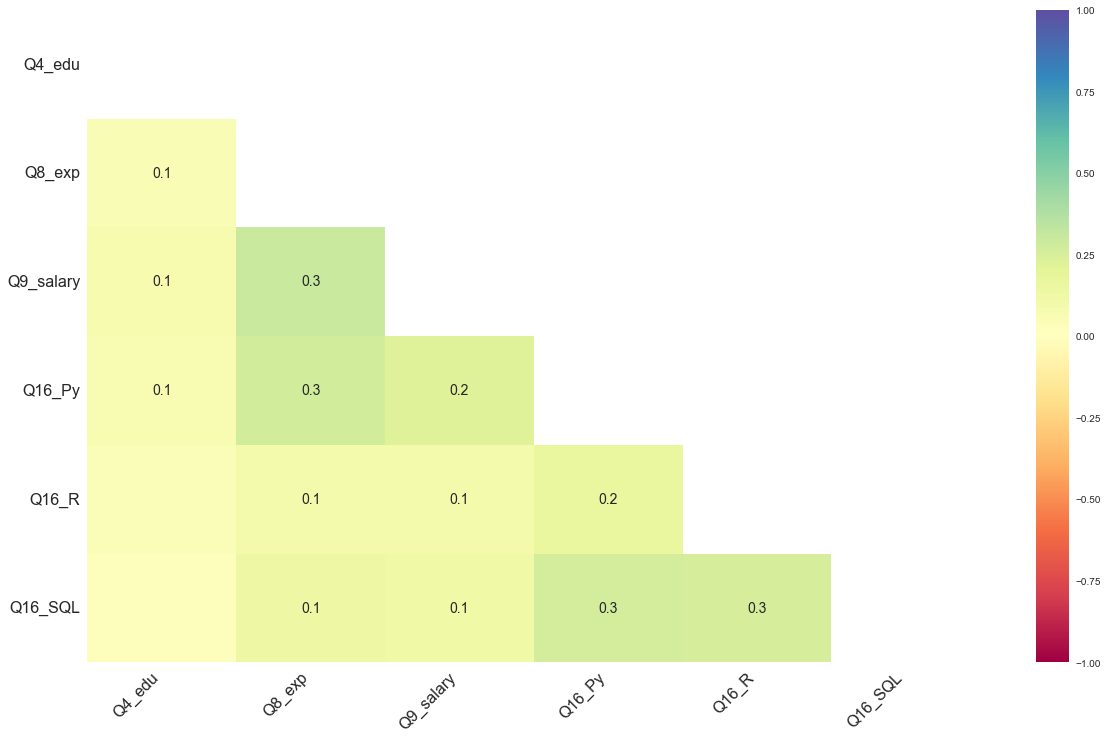

In [37]:
ax = mn.heatmap(X_bin, cmap='Spectral')

In [38]:
kag.fillna(0).corr()

,Q1_Male,Q2_age,Q3_United States of America,Q3_India,Q3_China,Q4_edu,Q5_other,Q5_stat,Q6_Data Scientist,Q6_Software Engineer,Q6_Consultant,Q8_exp,Q9_salary,Q16_Py,Q16_R,Q16_SQL
Q1_Male,1.000000,0.033629,-0.084065,0.033843,-0.000775,-0.006602,-0.010668,-0.052850,0.005684,0.058761,0.018565,0.050634,0.039703,0.076258,-0.048019,-0.006429
Q2_age,0.033629,1.000000,0.132143,-0.198489,-0.116152,0.115733,-0.036834,0.013775,0.019171,0.013876,0.147834,0.585056,0.346426,0.025954,0.108691,0.098681
Q3_United States of America,-0.084065,0.132143,1.000000,-0.236578,-0.135024,0.065516,-0.034630,0.042172,0.035660,-0.032322,0.011704,0.075847,0.337272,0.001896,0.100921,0.084695
Q3_India,0.033843,-0.198489,-0.236578,1.000000,-0.129664,-0.059726,-0.017797,-0.091178,-0.048707,0.034375,-0.017741,-0.081214,-0.180777,-0.012189,-0.022729,-0.025277
Q3_China,-0.000775,-0.116152,-0.135024,-0.129664,1.000000,-0.062286,0.023083,-0.017227,-0.078263,-0.024346,-0.044611,-0.027371,-0.098371,-0.004733,-0.101927,-0.091329
Q4_edu,-0.006602,0.115733,0.065516,-0.059726,-0.062286,1.000000,-0.102956,0.072293,0.107691,-0.023965,0.021329,0.098058,0.121327,0.190415,0.148231,0.082231
Q5_other,-0.010668,-0.036834,-0.034630,-0.017797,0.023083,-0.102956,1.000000,-0.603928,-0.080491,0.090536,-0.030408,-0.020790,-0.046716,-0.034434,-0.125767,-0.009836
Q5_stat,-0.052850,0.013775,0.042172,-0.091178,-0.017227,0.072293,-0.603928,1.000000,0.108797,-0.097683,0.014233,0.010863,0.042400,-0.002297,0.188669,0.039292
Q6_Data Scientist,0.005684,0.019171,0.035660,-0.048707,-0.078263,0.107691,-0.080491,0.108797,1.000000,-0.177971,-0.084477,-0.085383,0.154968,0.145166,0.121992,0.120178
Q6_Software Engineer,0.058761,0.013876,-0.032322,0.034375,-0.024346,-0.023965,0.090536,-0.097683,-0.177971,1.000000,-0.071673,0.083269,0.029984,0.023801,-0.142364,0.028822


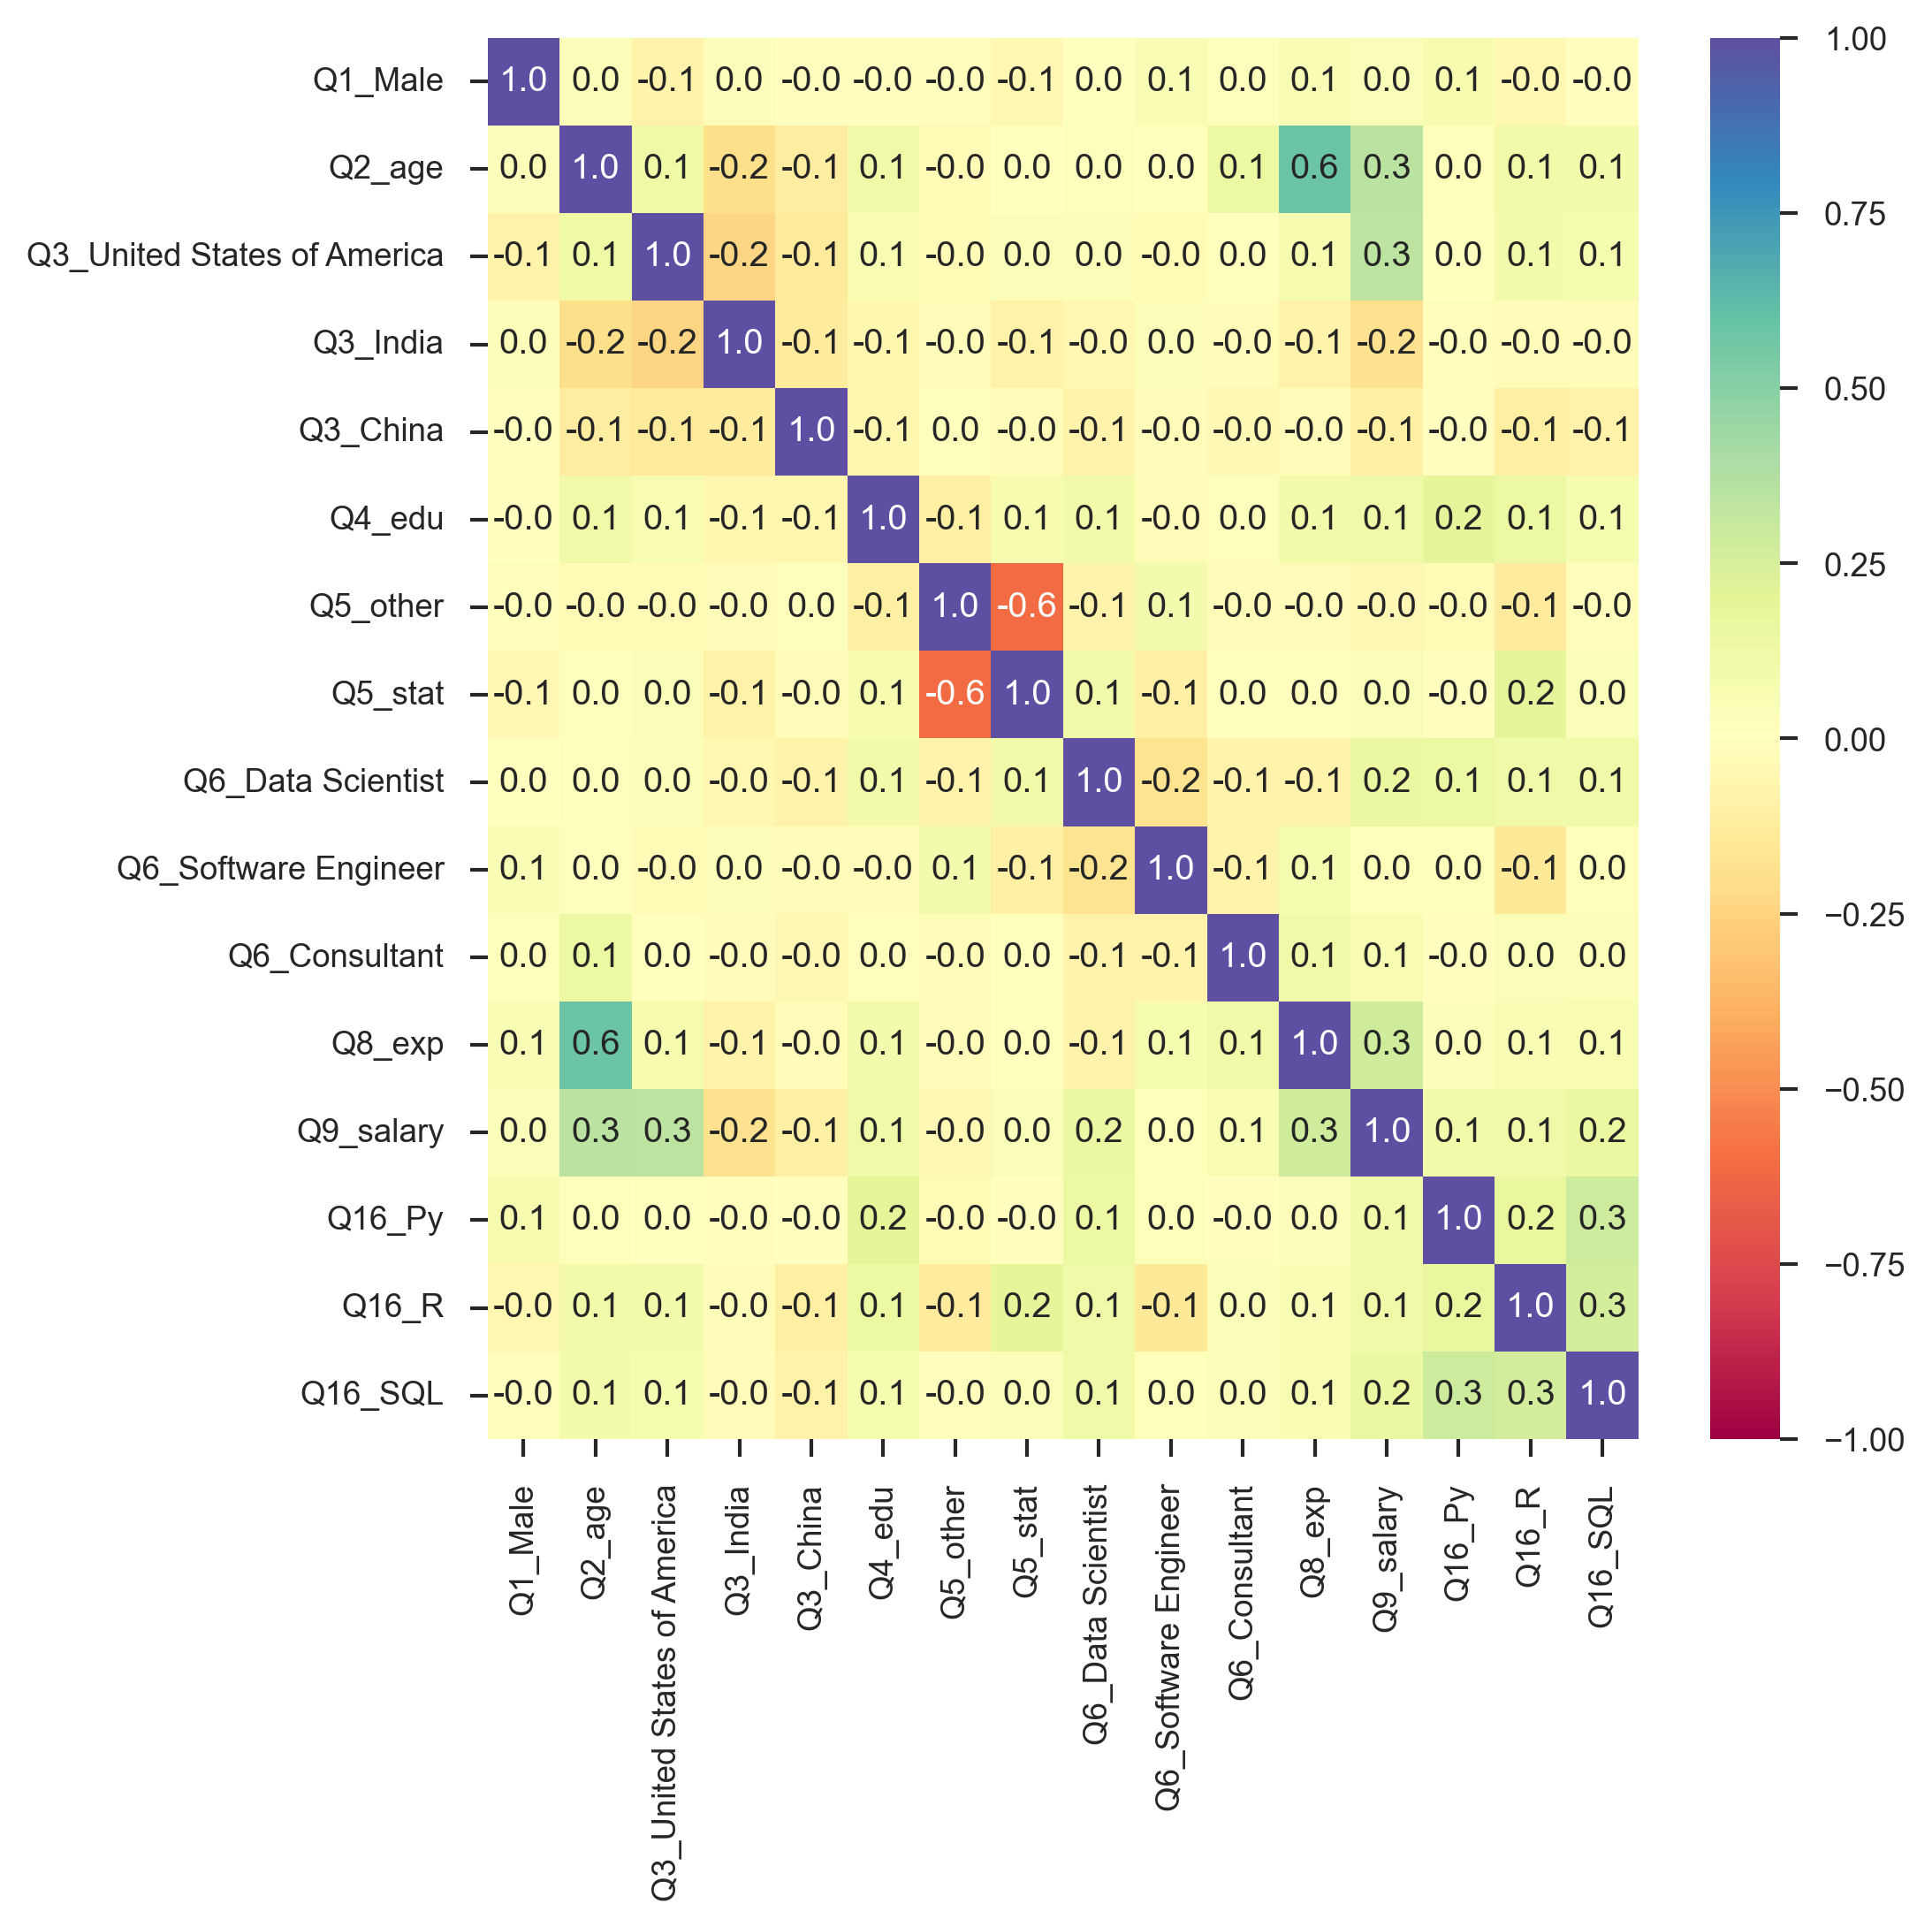

In [40]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(7,7), dpi=300)
    sns.heatmap(kag.fillna(0).corr(), cmap='Spectral', ax=ax,
                vmin=-1, vmax=1, annot=True, fmt='.1f')

In [41]:
kag.columns

Index(['Q1_Male', 'Q2_age', 'Q3_United States of America', 'Q3_India',
       'Q3_China', 'Q4_edu', 'Q5_other', 'Q5_stat', 'Q6_Data Scientist',
       'Q6_Software Engineer', 'Q6_Consultant', 'Q8_exp', 'Q9_salary',
       'Q16_Py', 'Q16_R', 'Q16_SQL'],
      dtype='object')

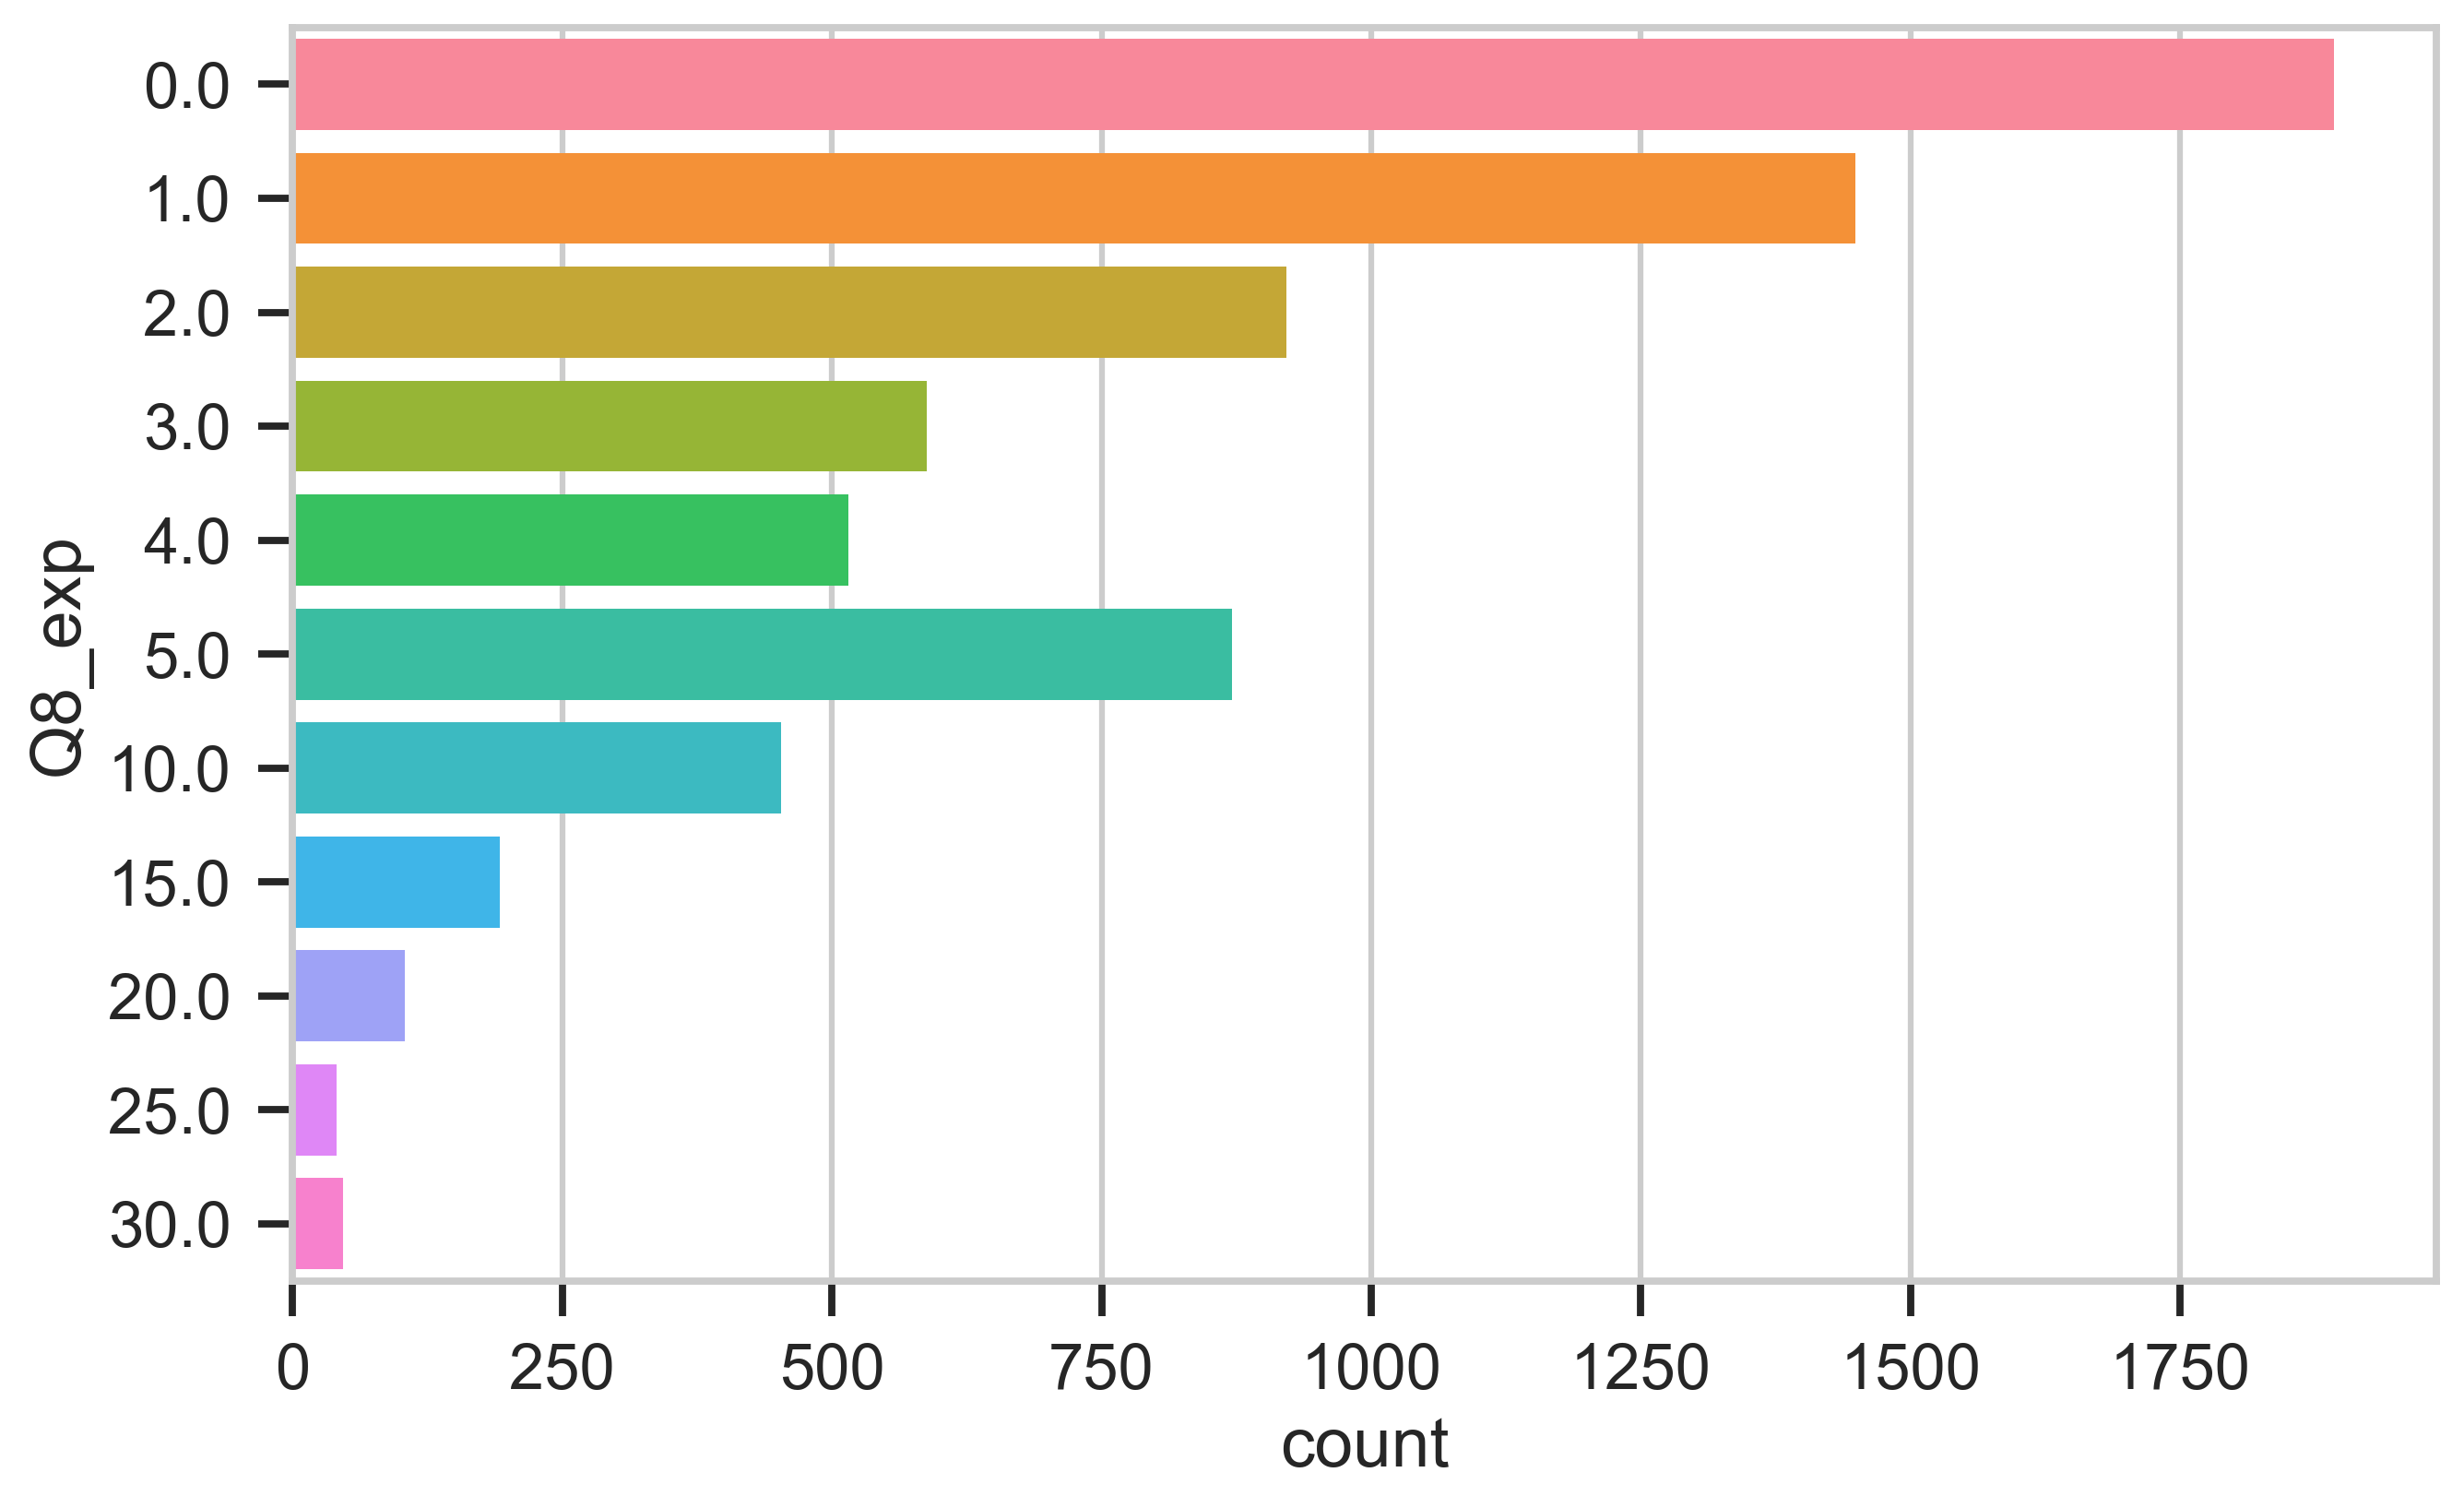

In [44]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    _ = sns.countplot(y='Q8_exp', data=X_bin, saturation=1, ax=ax)

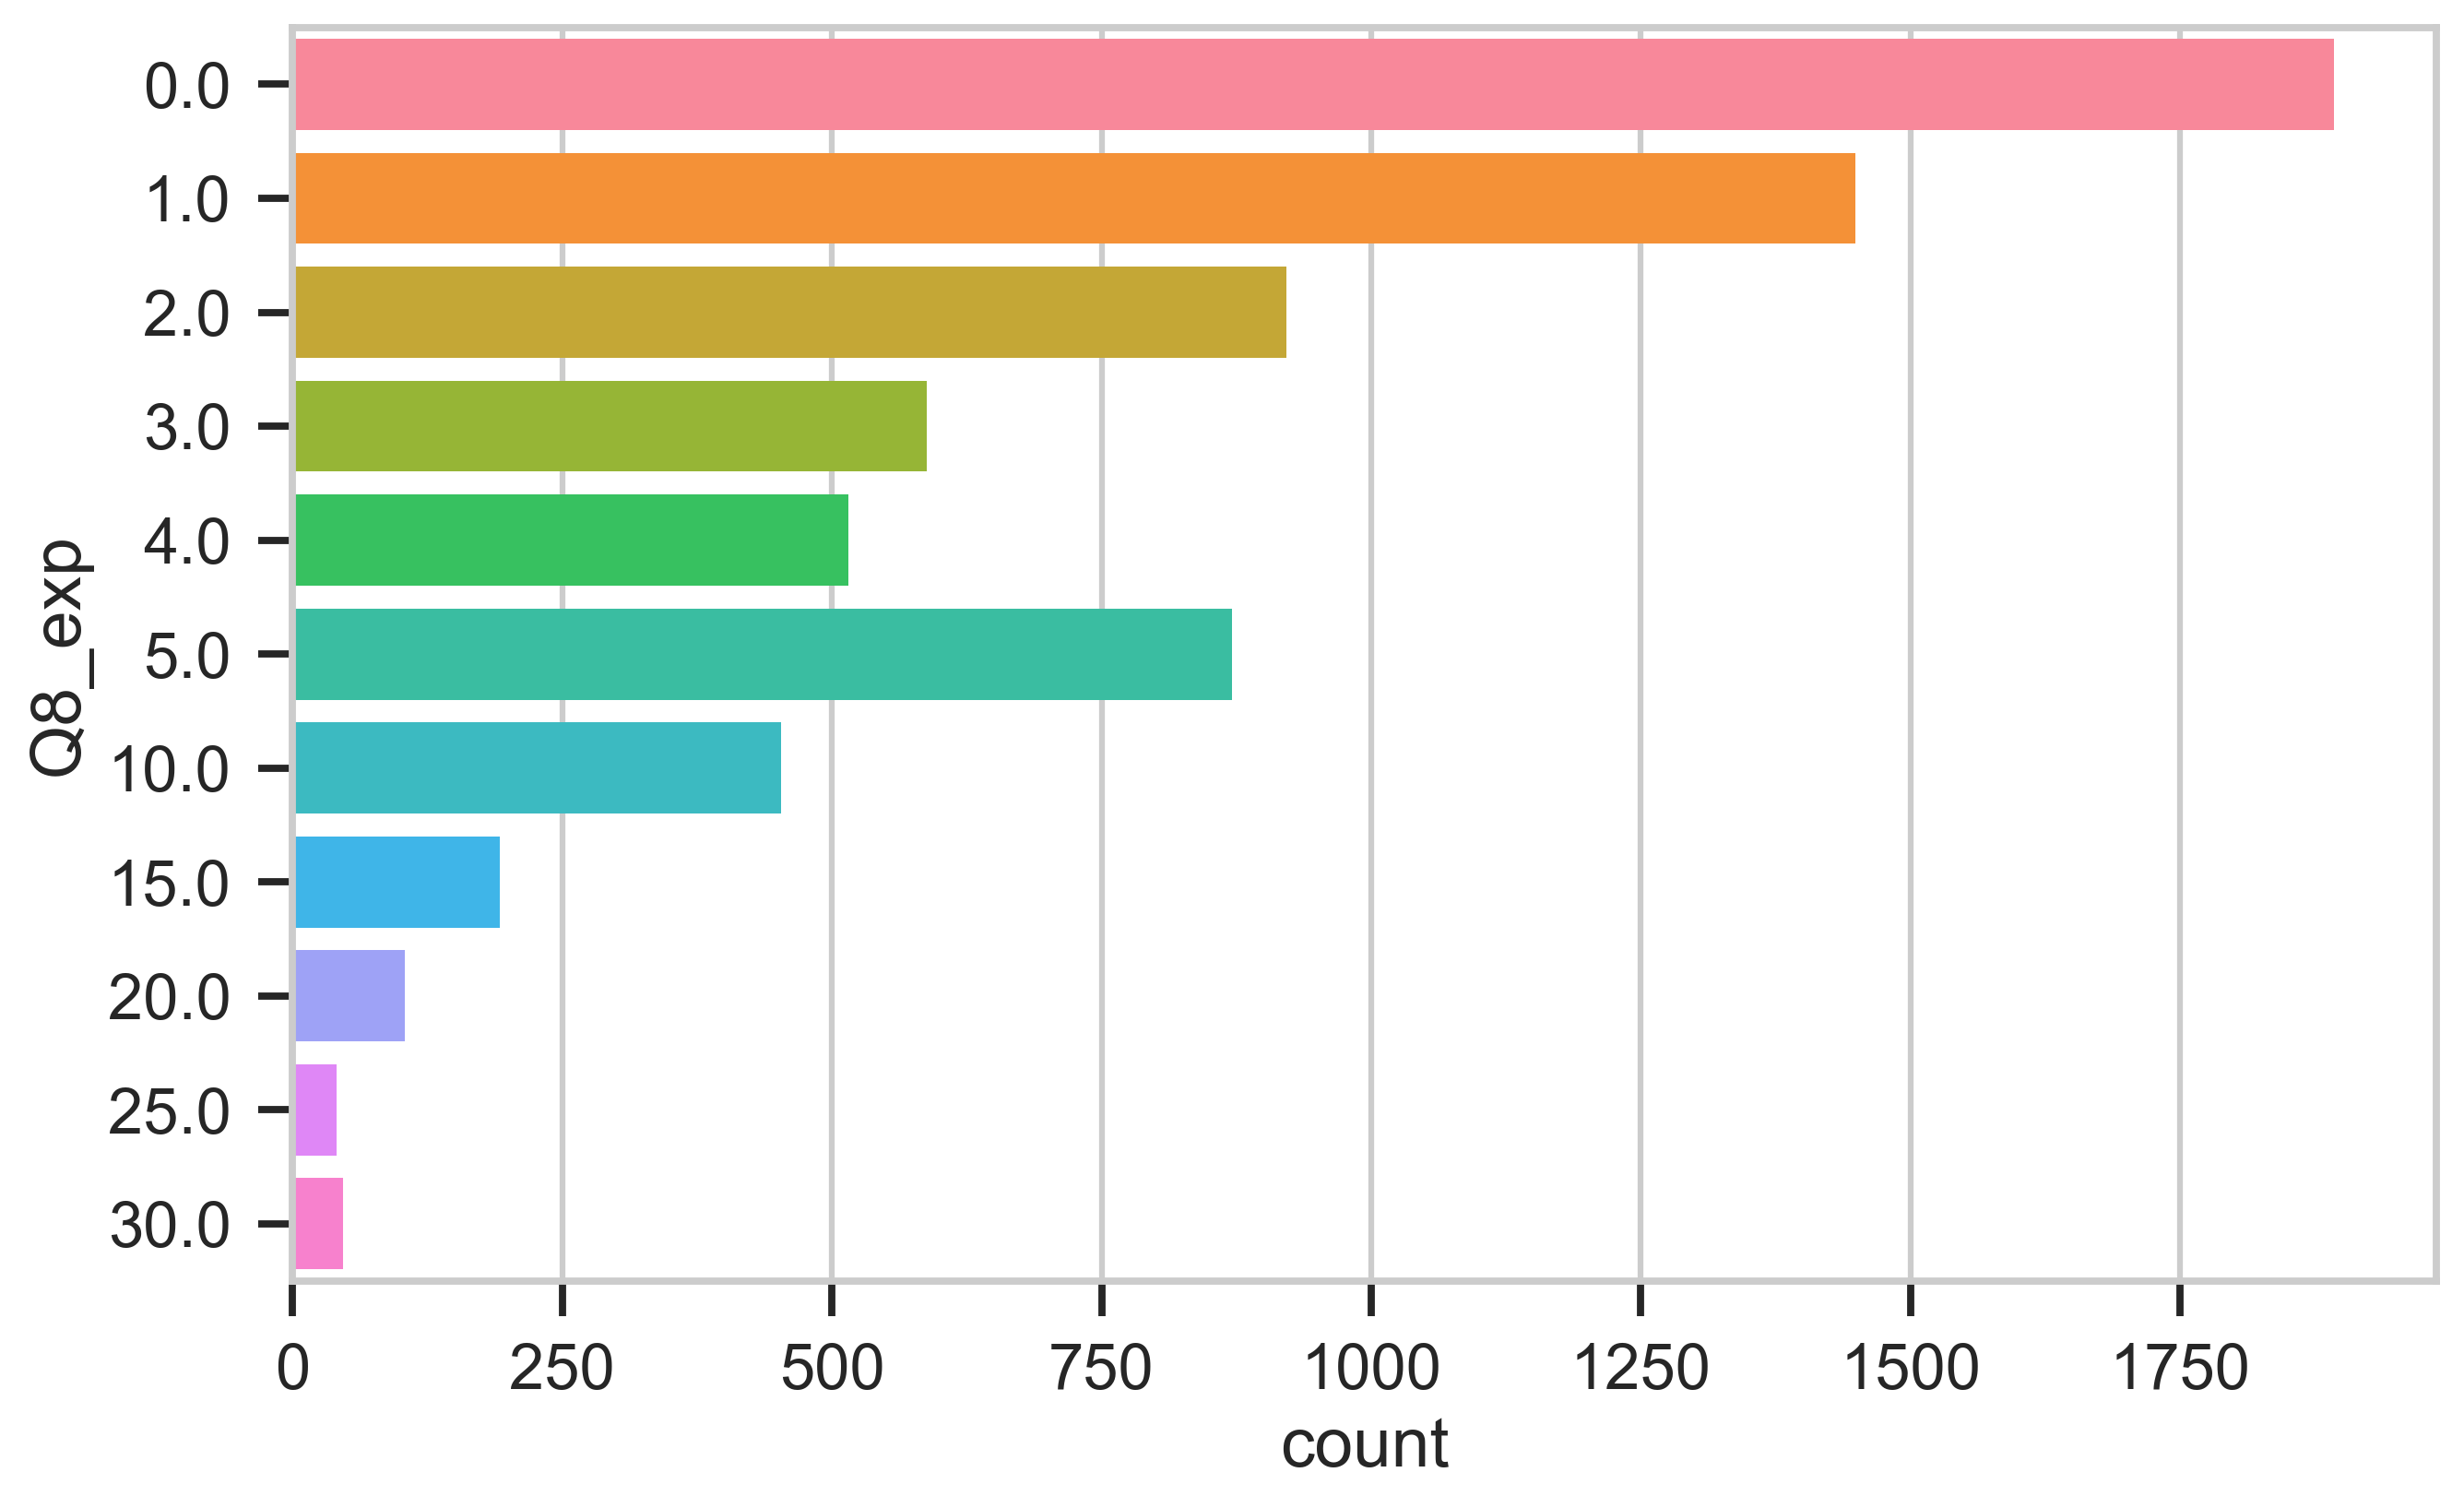

In [48]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    _ = sns.countplot(y='Q8_exp', data=X_bin, saturation=1, ax=ax)

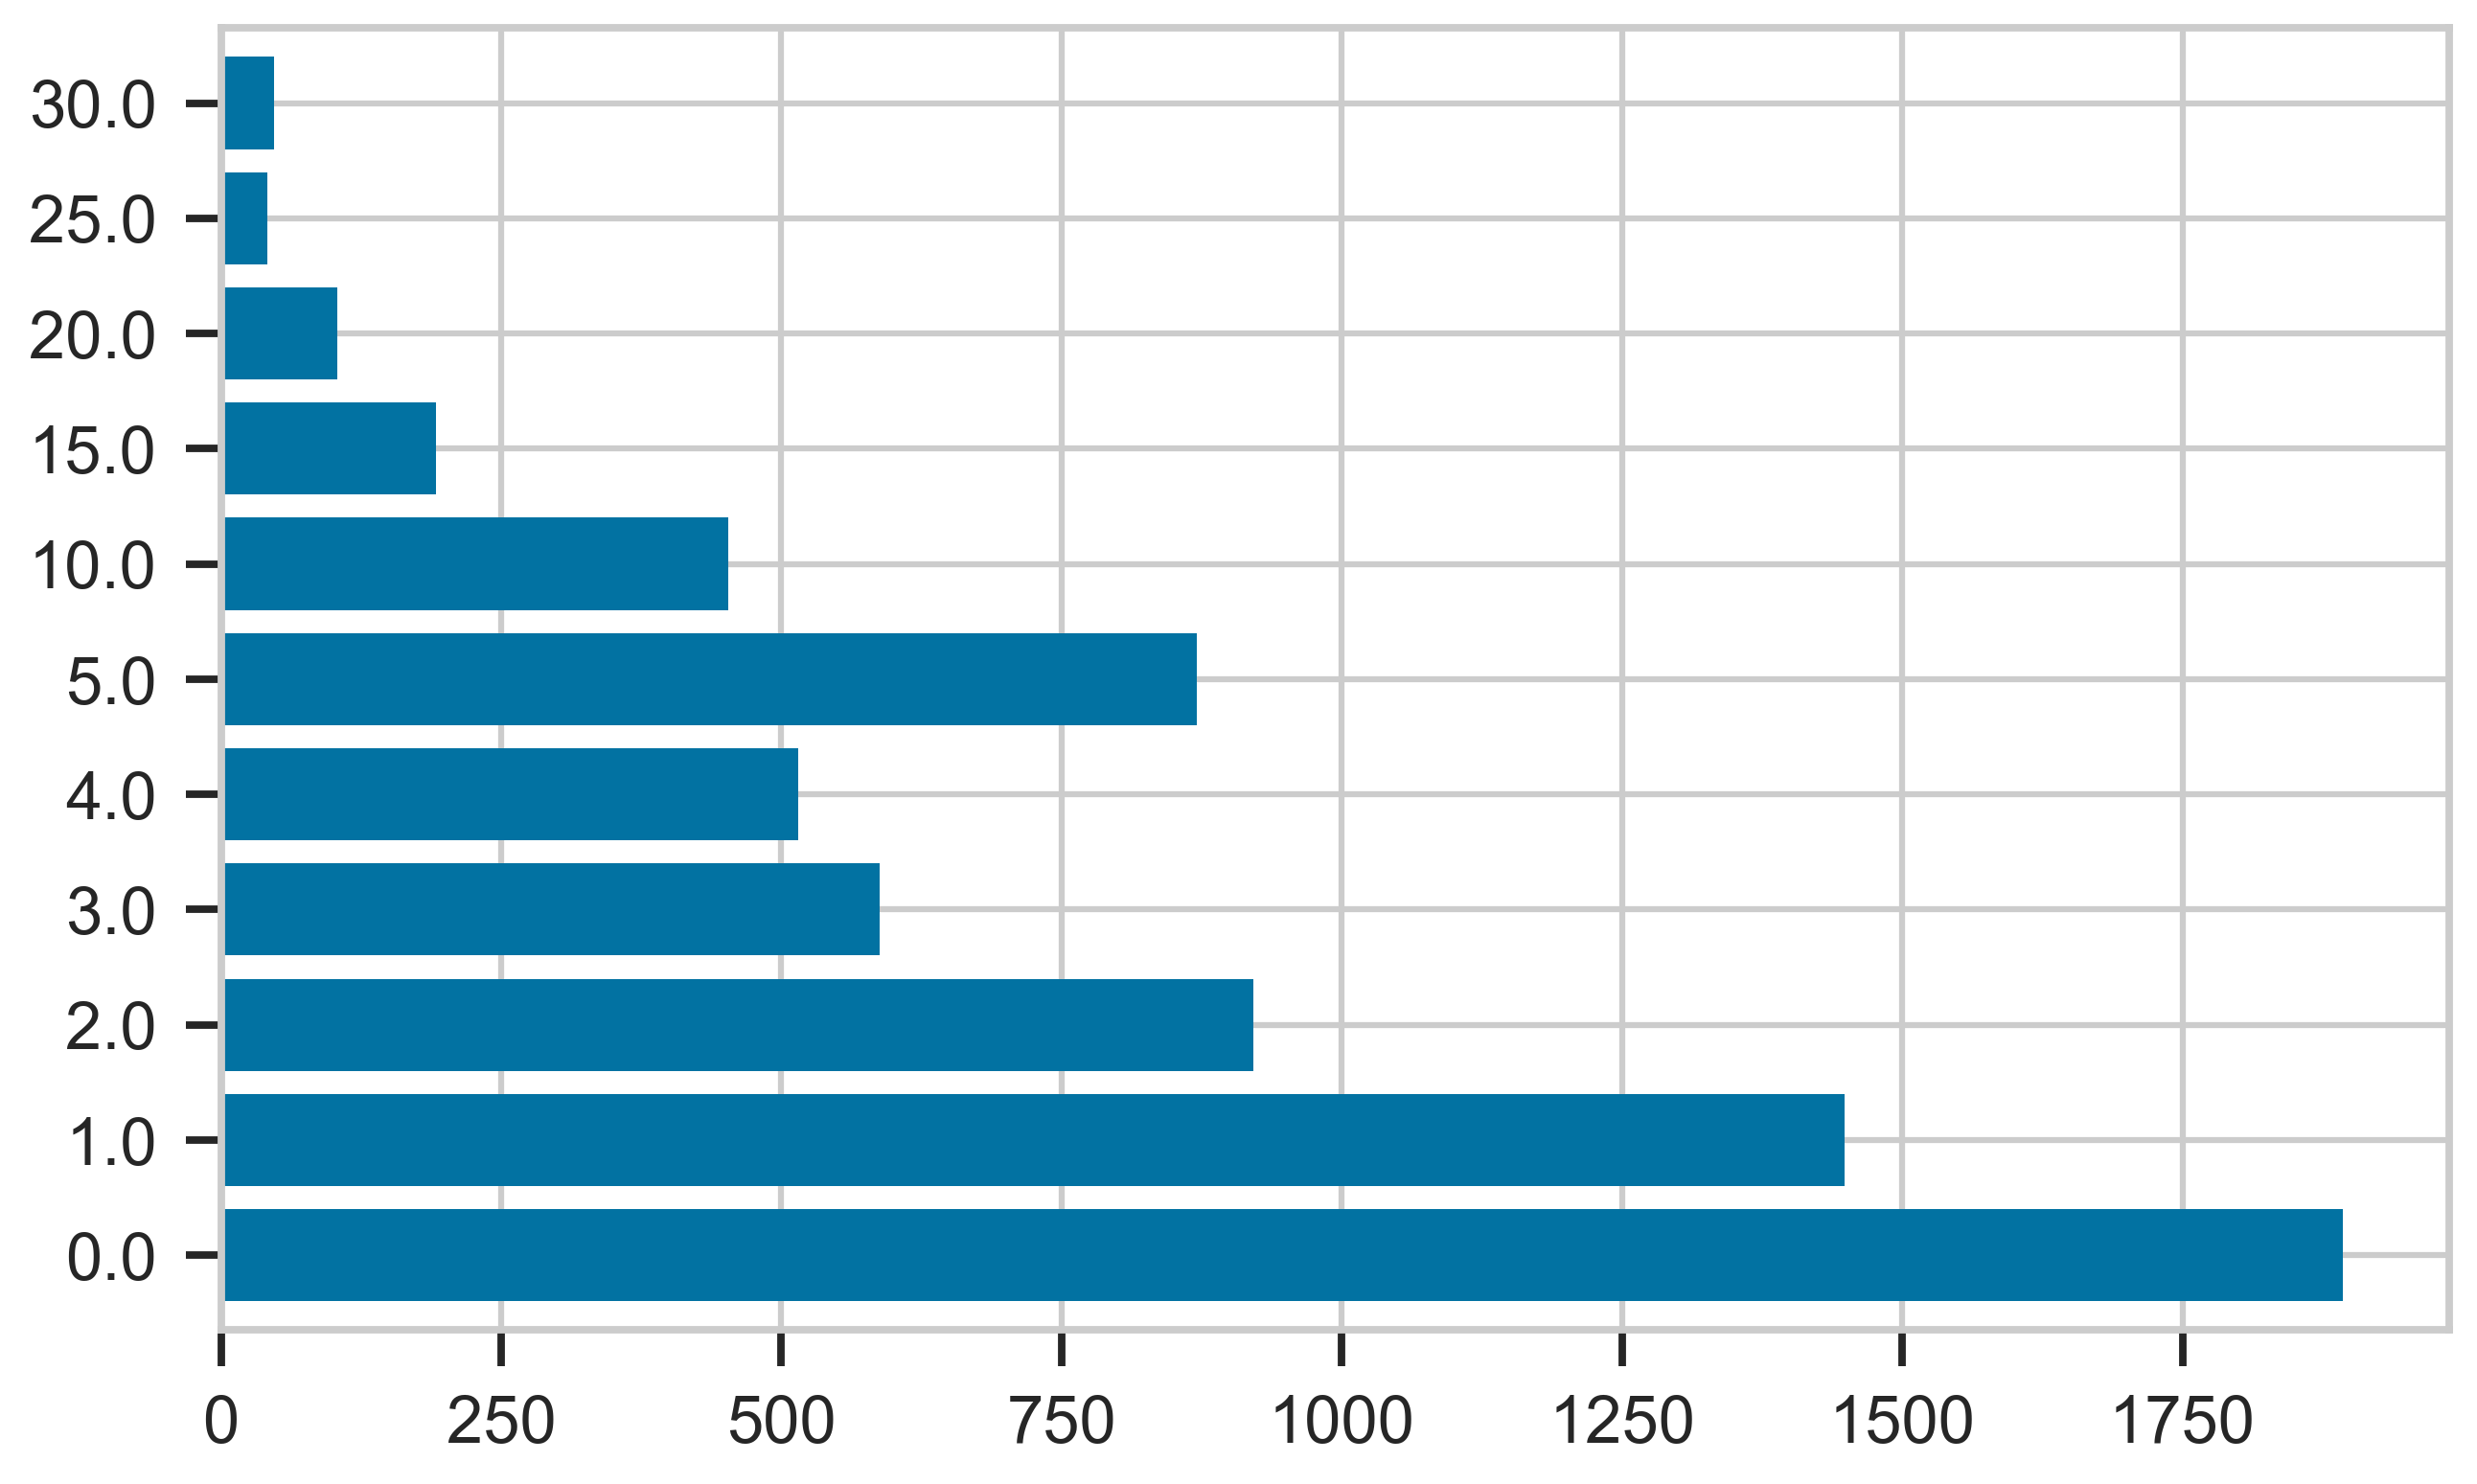

In [50]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    _ = X_bin.Q8_exp.value_counts().sort_index().plot.barh(width=.8, ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


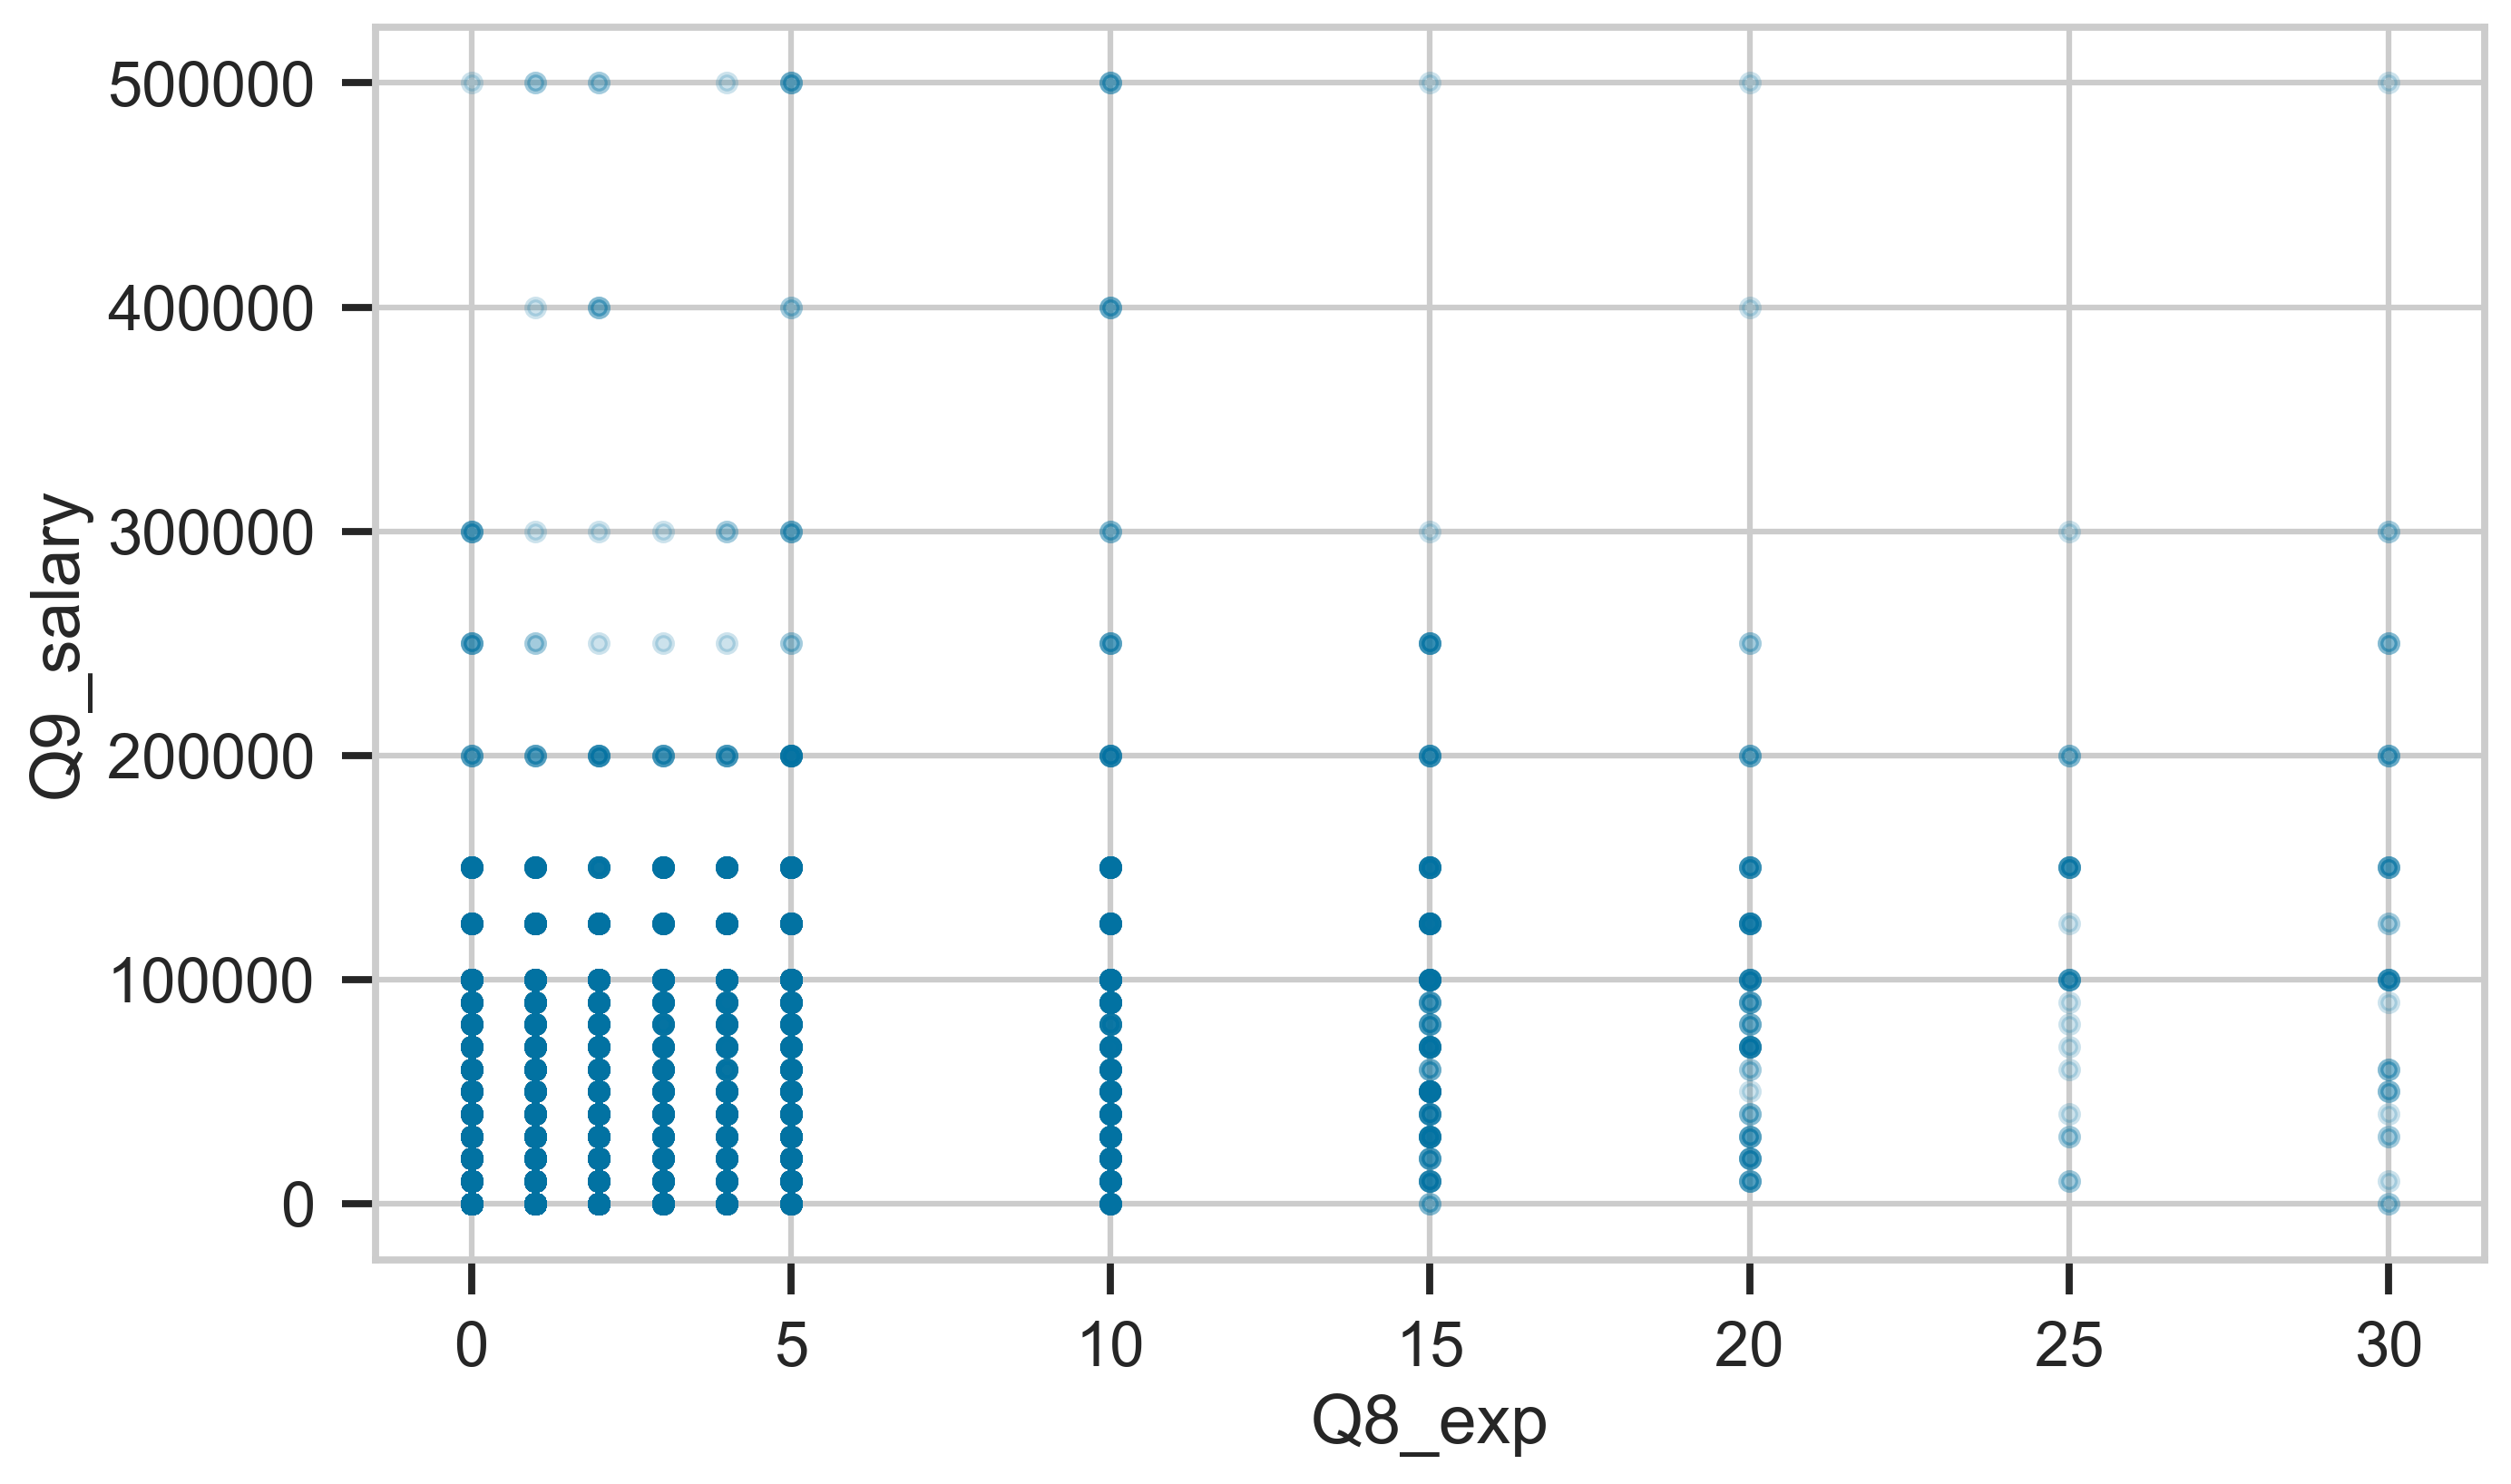

In [52]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    X_bin.plot.scatter(x='Q8_exp', y='Q9_salary', alpha=.2, ax=ax)

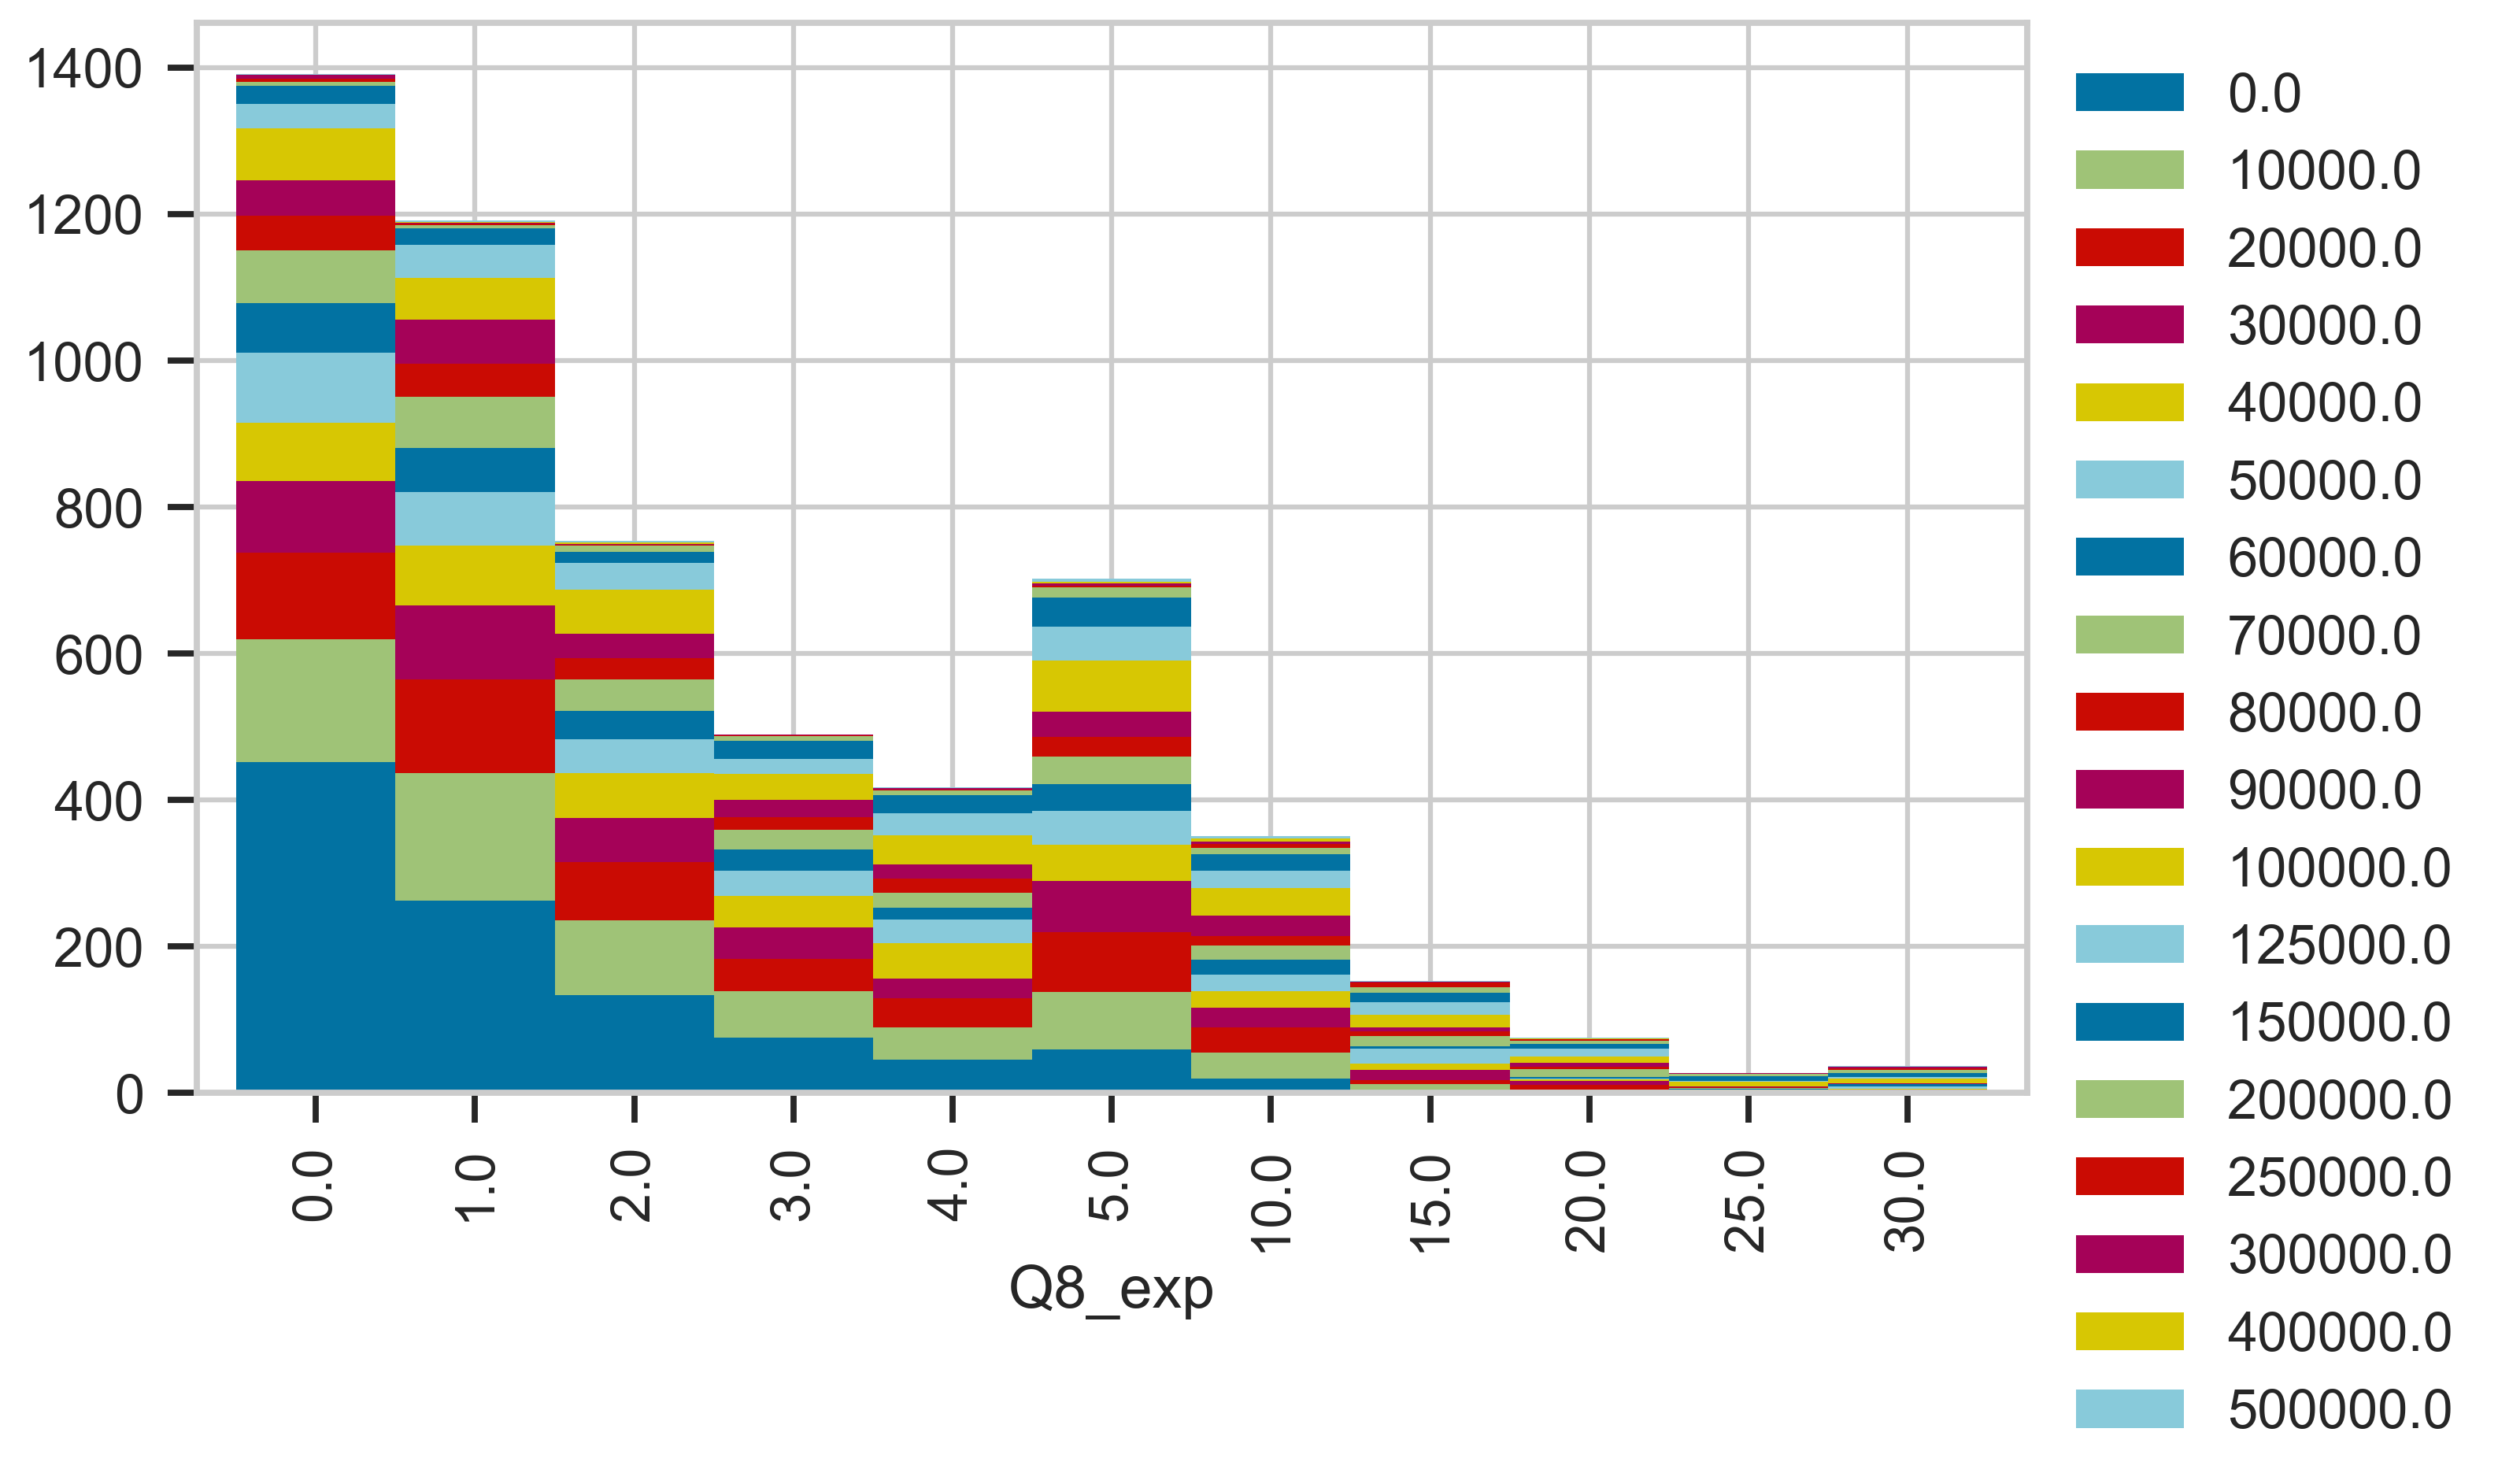

In [53]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    (X_bin
     .groupby(['Q8_exp', 'Q9_salary'])
     .size()
     .unstack()
     .plot.bar(stacked=True, width=1, ax=ax)
     .legend(bbox_to_anchor=(1,1))
    )

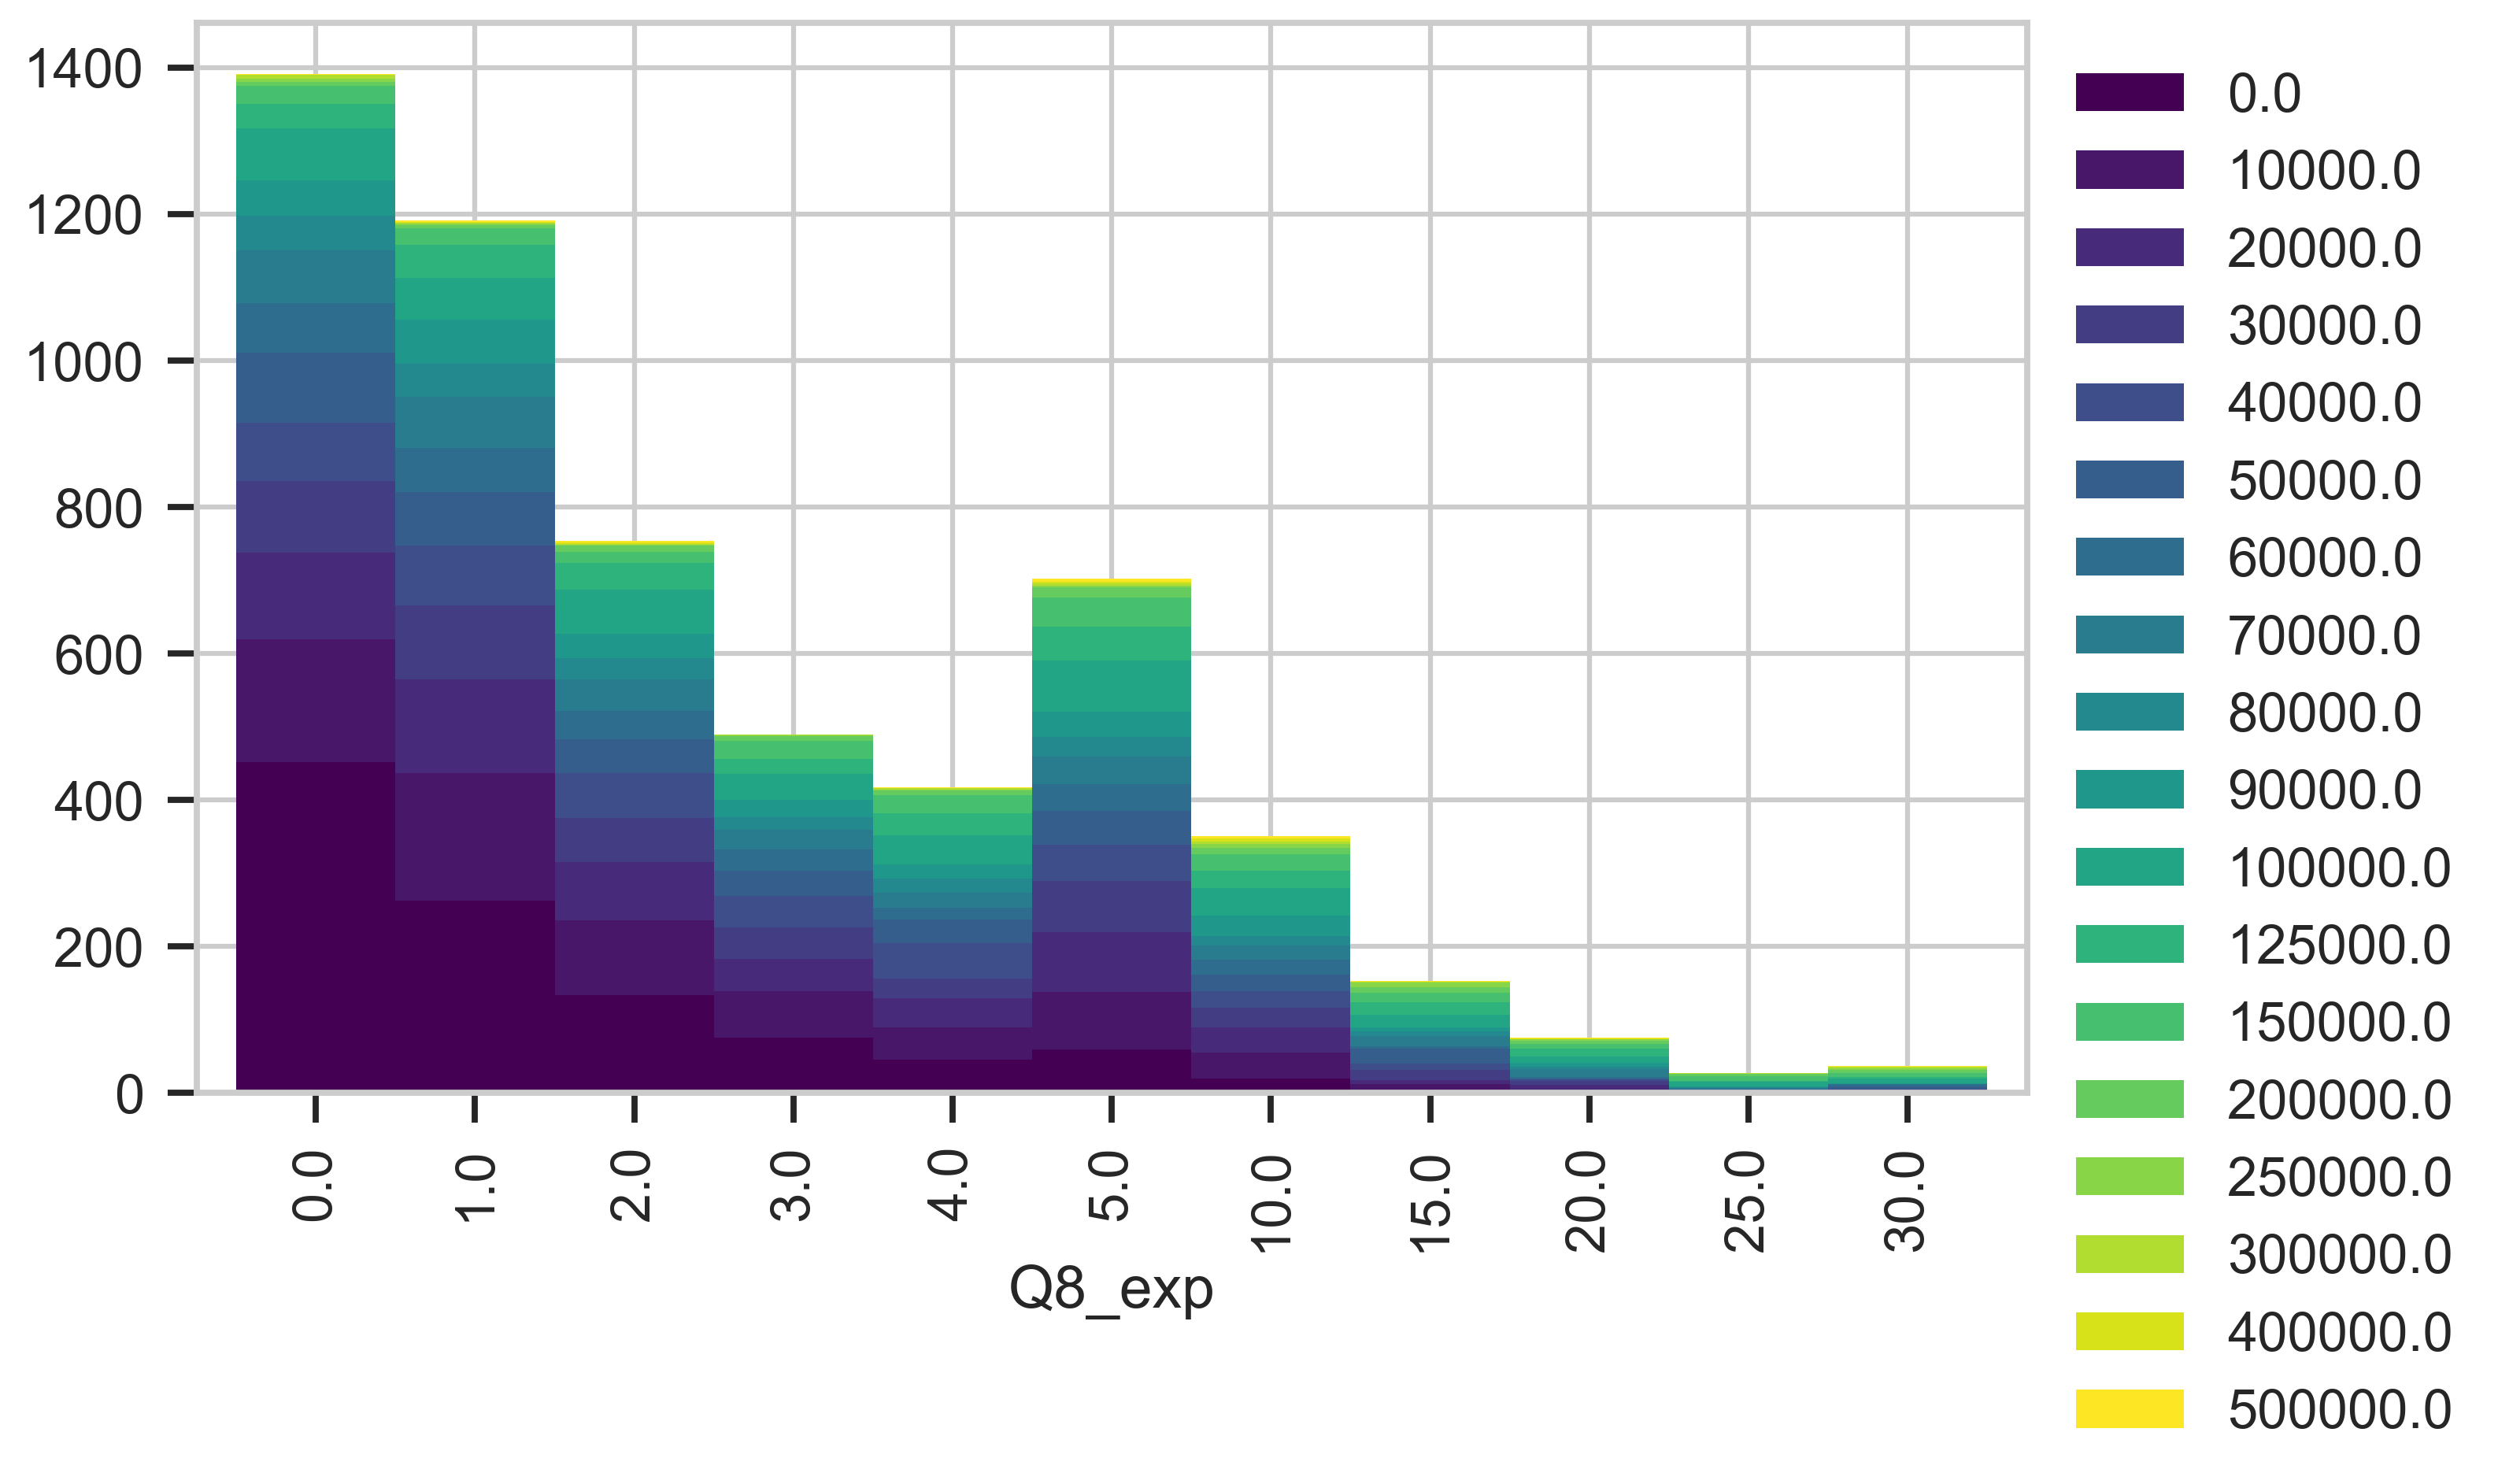

In [56]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    (X_bin
     .groupby(['Q8_exp', 'Q9_salary'])
     .size()
     .reset_index()
     .pivot(columns='Q9_salary', index='Q8_exp', values=0)
     .plot.bar(stacked=True, width=1, cmap='viridis', ax=ax)
     .legend(bbox_to_anchor=(1,1)))

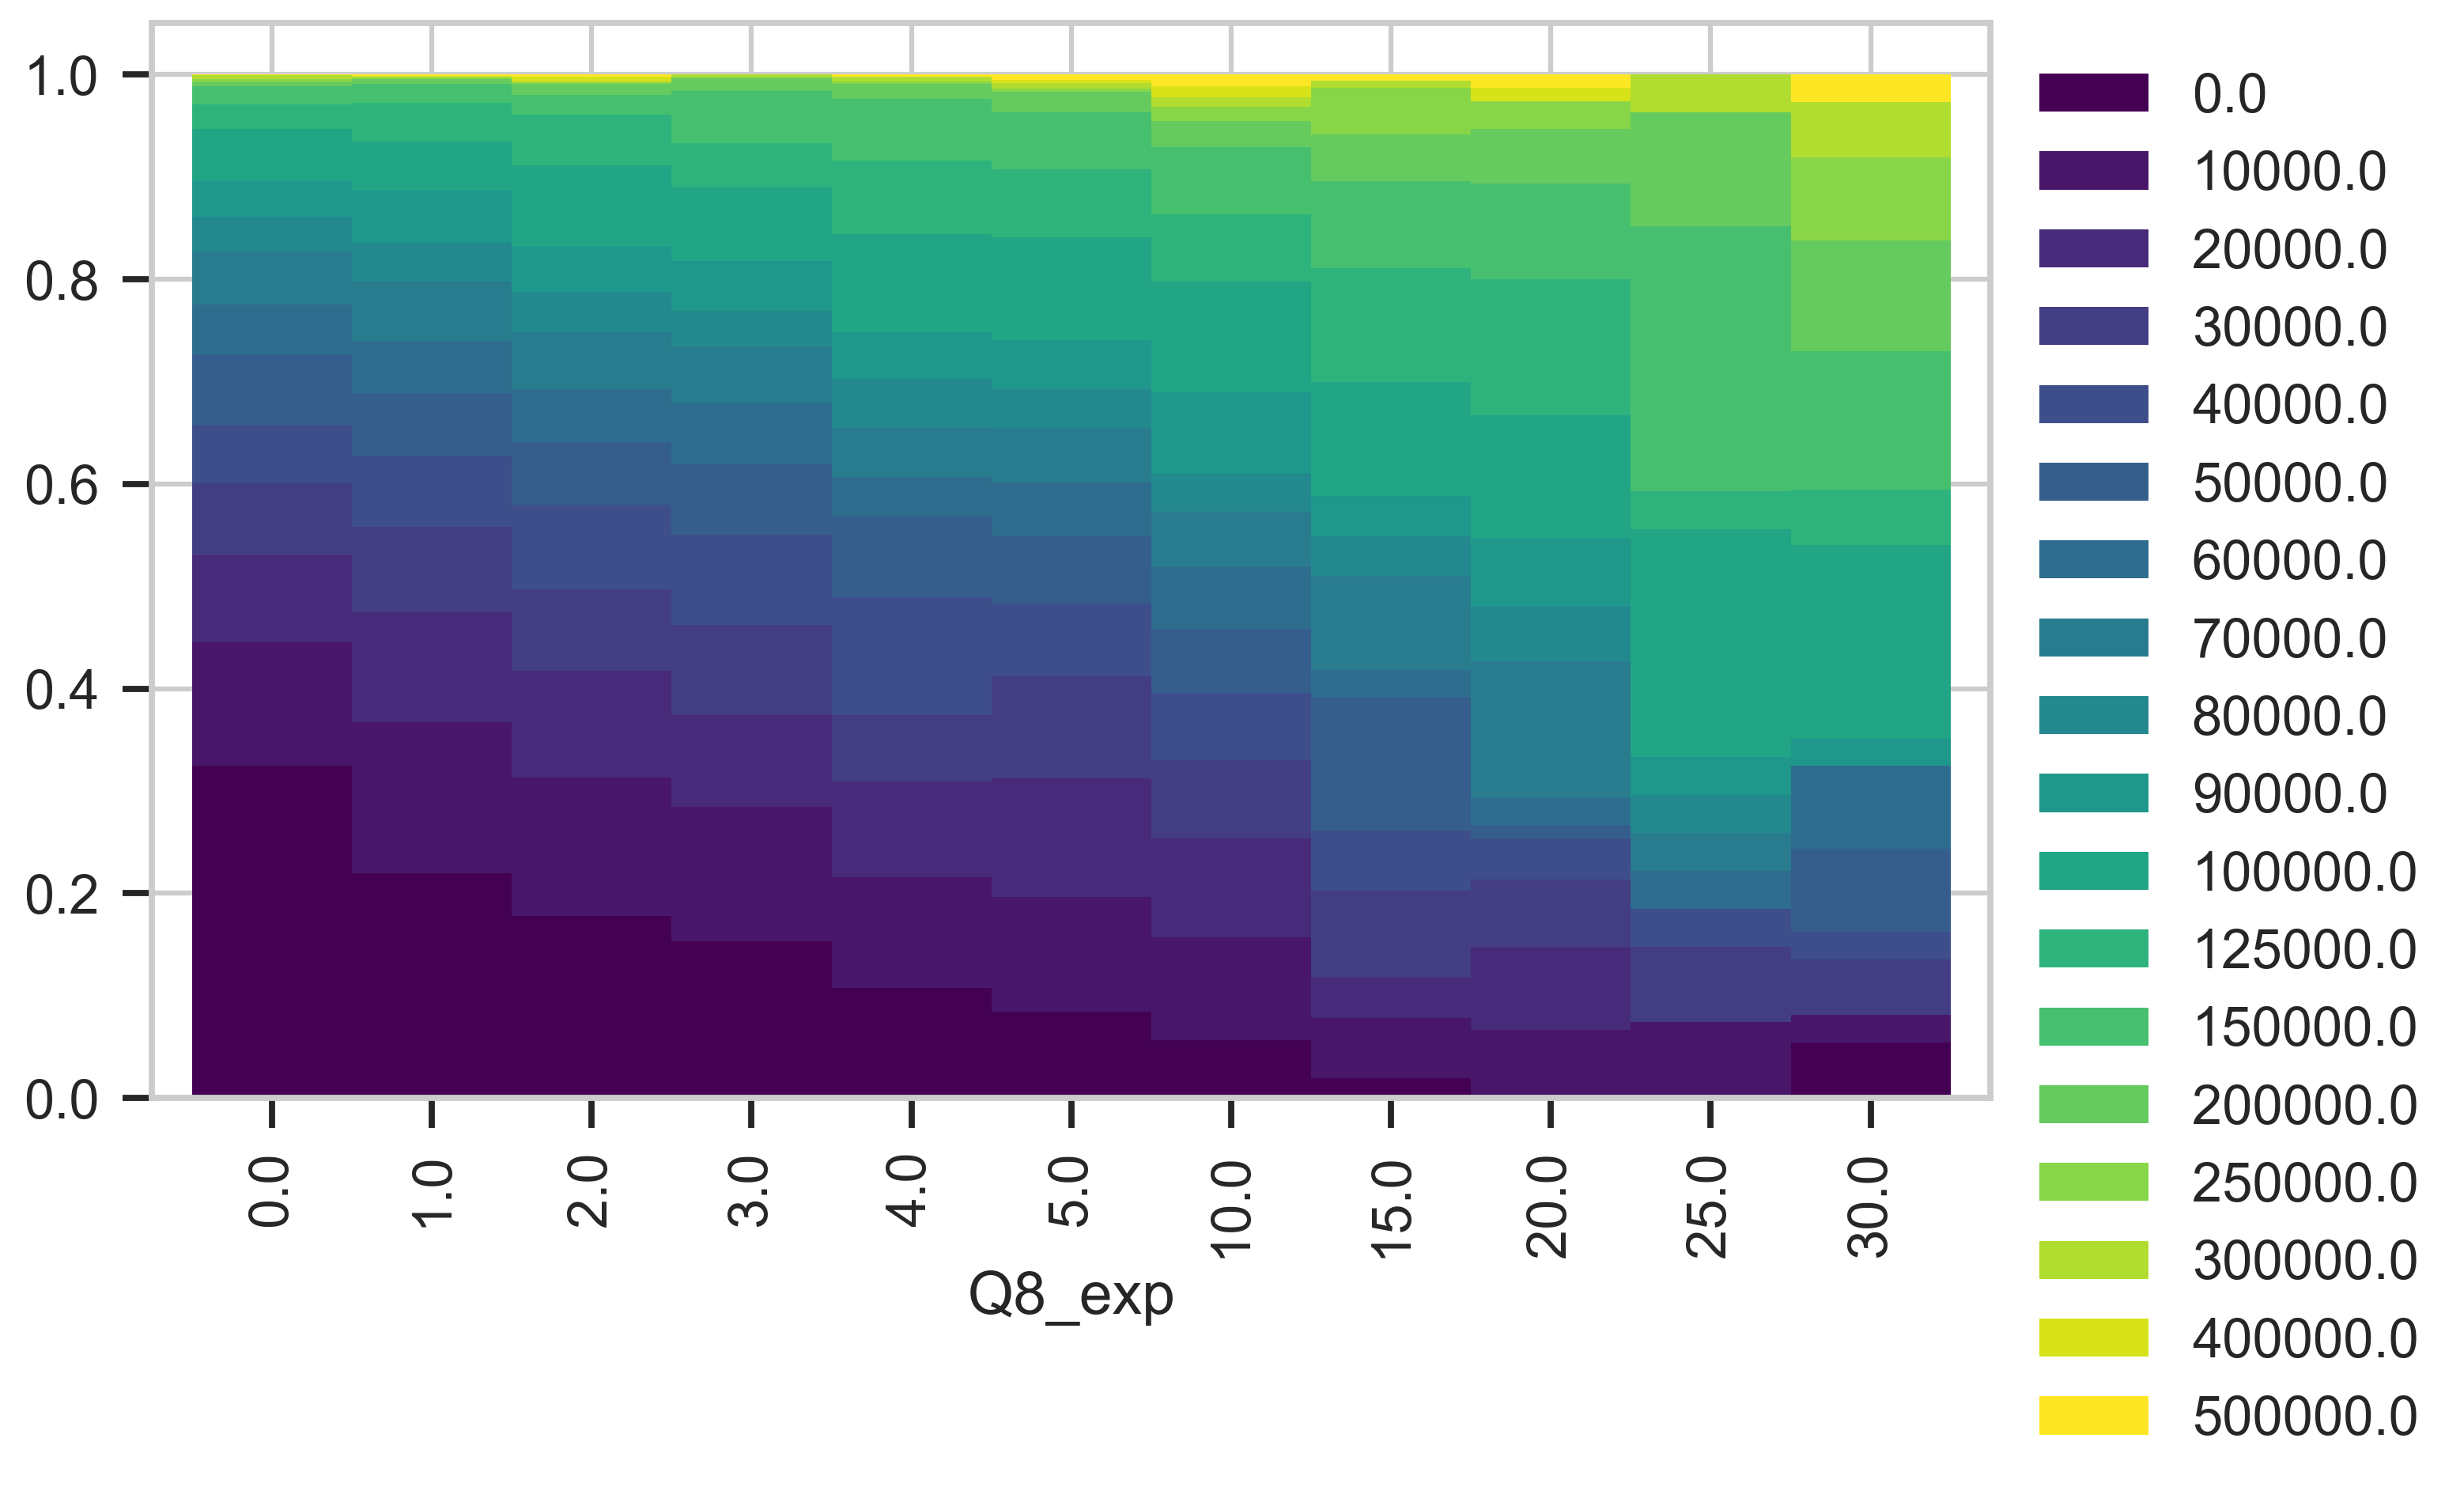

In [57]:
def div(df):
    return df.div(df.total, axis=0)

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    (X_bin
     .groupby(['Q8_exp', 'Q9_salary'])
     .size()
     .unstack()
     .assign(total=lambda df:df.sum(axis=1))
     .pipe(div)
     .drop(columns=['total'])
     .plot.bar(stacked=True, cmap='viridis', ax=ax, width=1)
     .legend(bbox_to_anchor=(1,1)))

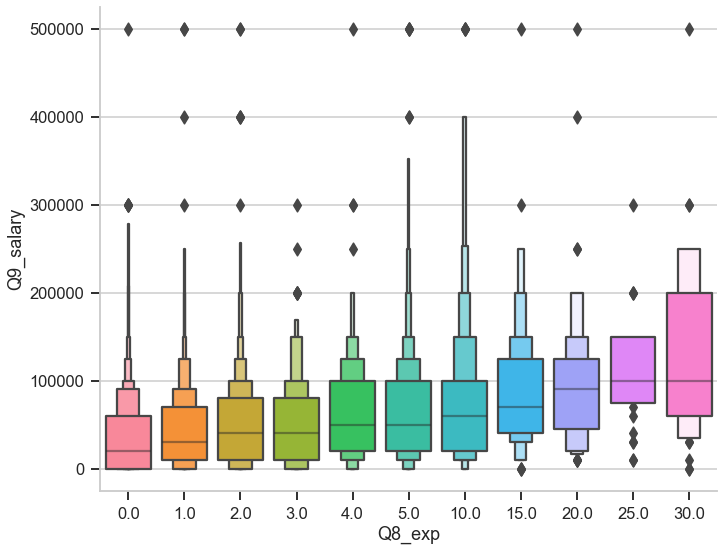

In [58]:
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q8_exp', data=X_bin,
                kind='boxen', height=8, aspect=1.3,
                saturation=1)

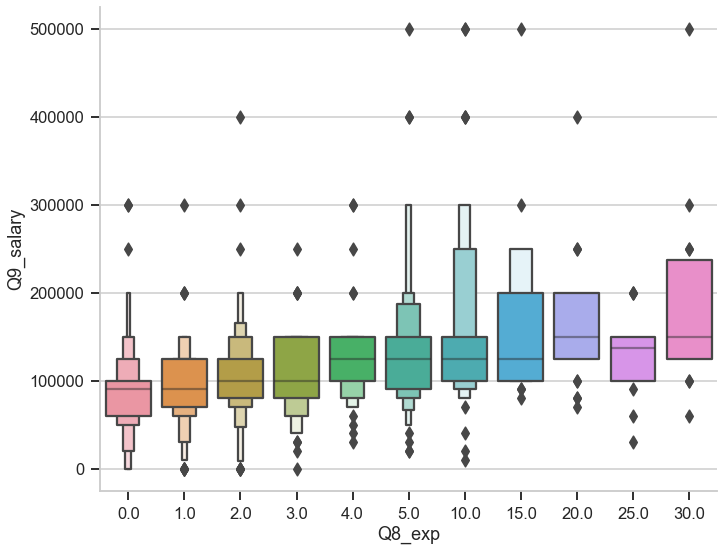

In [64]:
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q8_exp',
                data=X_bin[X_bin['Q3_United States of America'] == 1],
                kind='boxen', height=8, aspect=1.3)

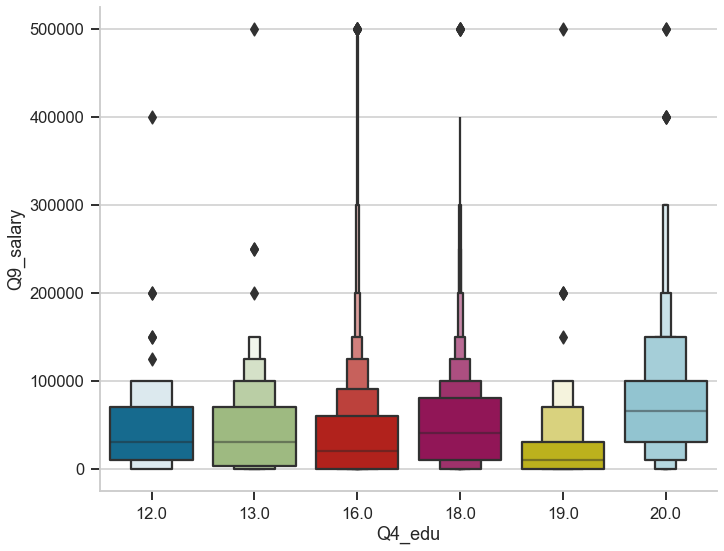

In [66]:
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q4_edu', data=X_bin,
                kind='boxen', height=8, aspect=1.3)

### Now baseline model

In [93]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
dc.fit(X_bin_train.fillna(0), y_bin_train)
dc.score(X_bin_test.fillna(0), y_bin_test)

0.5694635488308115

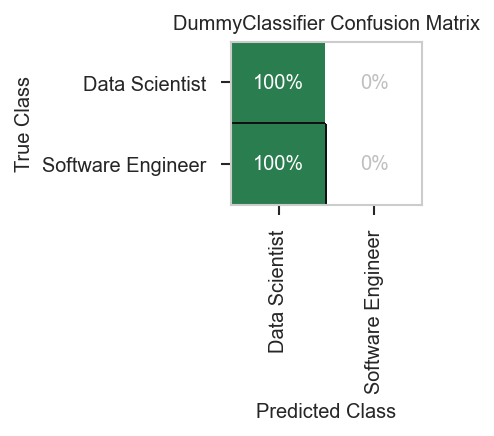

In [84]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(3,3), dpi=150)
    cm_viz = classifier.ConfusionMatrix(dc, percent=True)
    cm_viz.fit(X_bin_train.fillna(0), y_bin_train)
    cm_viz.score(X_bin_test.fillna(0), y_bin_test)
    cm_viz.poof()

In [87]:
dtc = tree.DecisionTreeClassifier(max_depth=8)
dtc.fit(X_bin_train.fillna(0), y_bin_train)
dtc.score(X_bin_test.fillna(0), y_bin_test)

0.7143512150389729

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


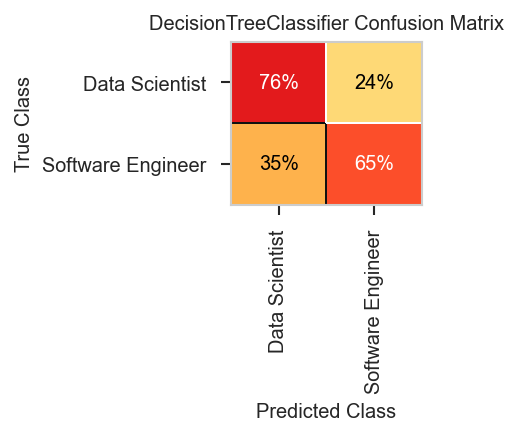

In [75]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(3,3), dpi=150)
    cm_viz = classifier.ConfusionMatrix(dtc, percent=True)
    cm_viz.fit(X_bin_train.fillna(0), y_bin_train)
    cm_viz.score(X_bin_test.fillna(0), y_bin_test)
    cm_viz.poof()

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide


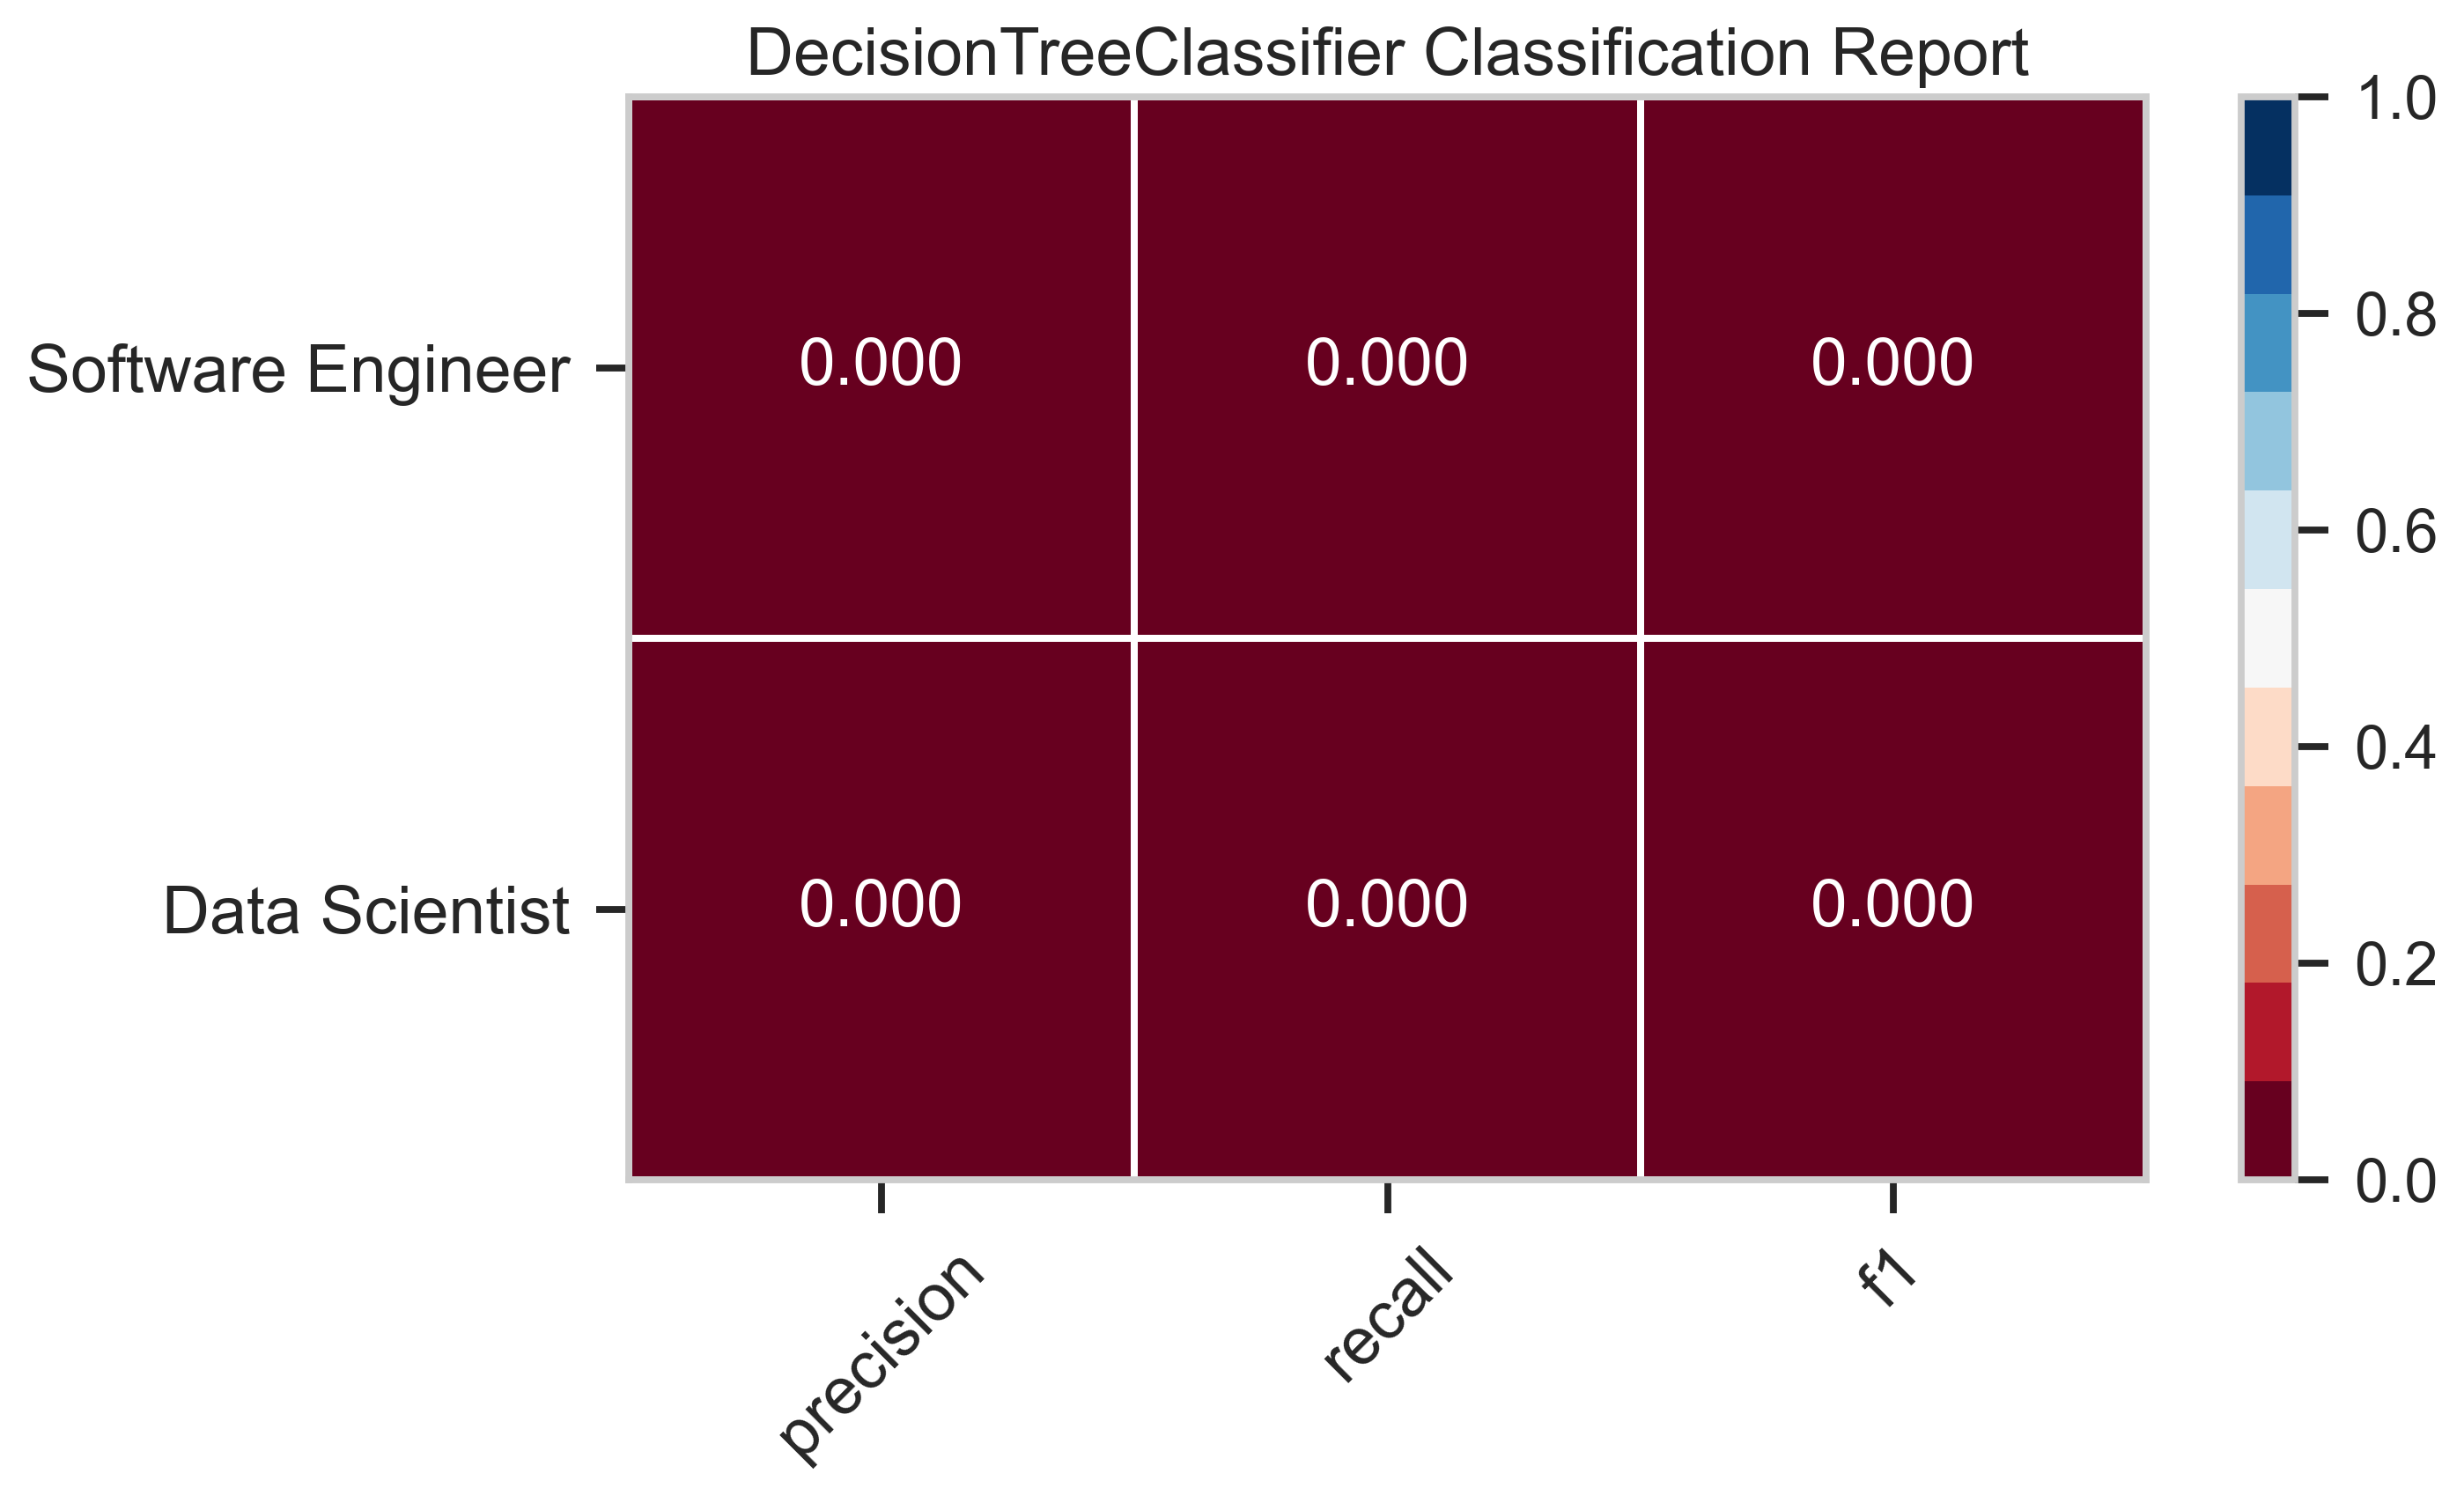

In [76]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    cr_viz = classifier.ClassificationReport(dtc, cmap=None)
    cr_viz.fit(X_bin_train.fillna(0), y_bin_train)
    cr_viz.score(X_bin_test.fillna(0), y_bin_test)
    cr_viz.poof()

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


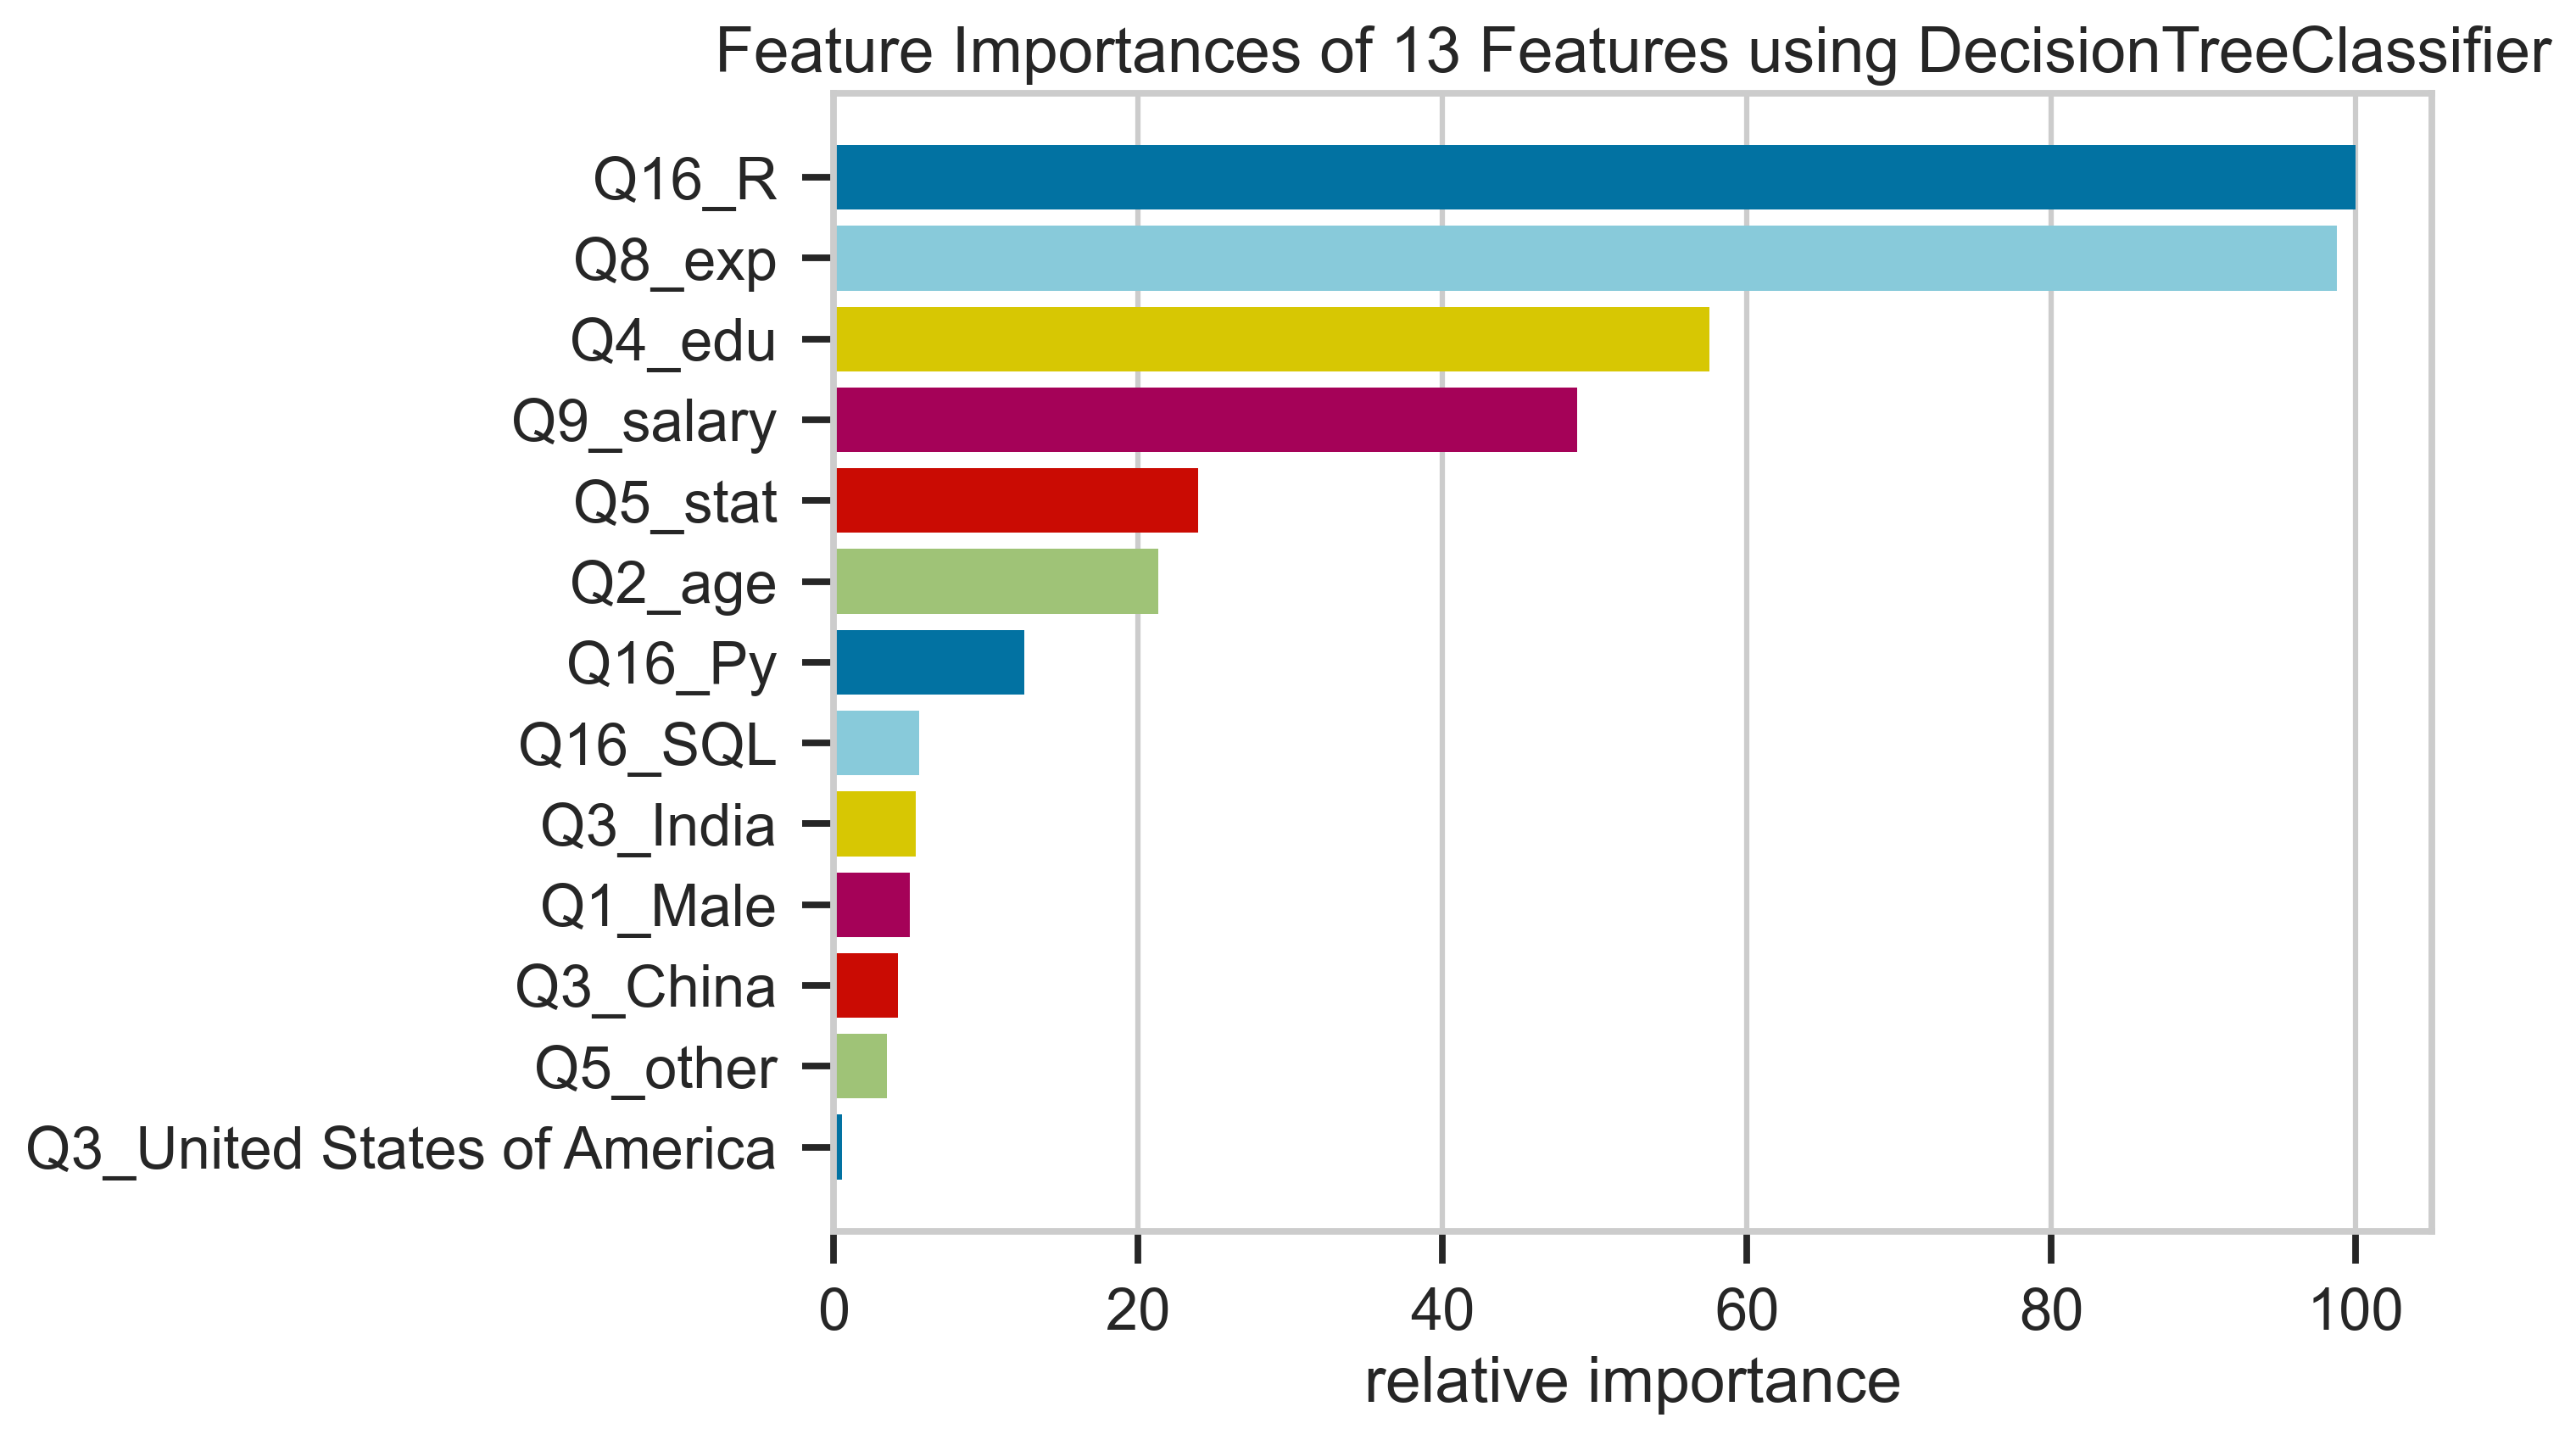

In [77]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    fi_viz = features.FeatureImportances(dtc)
    fi_viz.fit(X_bin_train.fillna(0), y_bin_train)
    fi_viz.score(X_bin_test.fillna(0), y_bin_test)
    fi_viz.poof()

In [91]:
X_bin.isna().mean()*100

Q1_Male                         0.000000
Q2_age                          0.000000
Q3_United States of America     0.000000
Q3_India                        0.000000
Q3_China                        0.000000
Q4_edu                          1.403605
Q5_other                        0.000000
Q5_stat                         0.000000
Q8_exp                          2.655841
Q9_salary                      23.090684
Q16_Py                         24.342920
Q16_R                          72.258153
Q16_SQL                        56.722169
dtype: float64

In [102]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_bin_train, y_bin_train_mod)
xgb.score(X_bin_test, y_bin_test_mod)

0.7258138468592389

In [103]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [104]:
print(xgb.get_booster().get_dump()[0])

0:[Q16_R<-9.53674316e-07] yes=1,no=2,missing=1
	1:[Q8_exp<2.5] yes=3,no=4,missing=3
		3:[Q4_edu<17] yes=7,no=8,missing=7
			7:[Q5_stat<1] yes=15,no=16,missing=15
				15:[Q16_Py<-9.53674316e-07] yes=31,no=32,missing=31
					31:[Q2_age<20] yes=61,no=62,missing=61
						61:leaf=-0.0720000044
						62:leaf=-0.214973271
					32:[Q3_India<1] yes=63,no=64,missing=63
						63:leaf=0.0188034195
						64:leaf=-0.15625
				16:[Q8_exp<1.5] yes=33,no=34,missing=33
					33:leaf=0.404081643
					34:[Q9_salary<5000] yes=65,no=66,missing=65
						65:leaf=0.150000006
						66:leaf=-0.150000006
			8:[Q9_salary<25000] yes=17,no=18,missing=17
				17:[Q5_stat<1] yes=35,no=36,missing=35
					35:[Q4_edu<19.5] yes=67,no=68,missing=68
						67:leaf=0.013024603
						68:leaf=0.378947377
					36:[Q2_age<33] yes=69,no=70,missing=69
						69:leaf=0.482926846
						70:leaf=0.225000009
				18:[Q16_Py<-9.53674316e-07] yes=37,no=38,missing=37
					37:[Q2_age<24] yes=71,no=72,missing=71
						71:leaf=-0.150000006
						

In [111]:
import re

def plot_xgb(xgb, title='', size='8.5', num_trees=0):
    g2 = xgboost.to_graphviz(xgb, label=title, labelloc='top',
                             fontname='Gotham', fontsize='16', no_color="#a62e5c",
                             yes_color="#9bc850", size=size, num_trees=num_trees)
    reg = r'([0-9]+([.]([0-9]*)?))'
    for i, line in enumerate(g2.body):
        match = re.search(reg, line)
        if match:
            orig = match.group(1)
            val = '{:.5}'.format(orig)
            g2.body[i] = line.replace(orig, val)
    g2.node_attr={'fontname': 'Gotham'}
    g2.edge_attr={'fontname': 'Gotham'}
    return g2

In [116]:
xgb.score(X_bin_train, y_bin_train_mod)

0.8495871018482107

In [117]:
xgb.score(X_bin_test, y_bin_test_mod)

0.7258138468592389

In [118]:
dtc.score(X_bin_test.fillna(0), y_bin_test)

0.7143512150389729

In [119]:
dtc.score(X_bin_train.fillna(0), y_bin_train)

0.7709398348407392

could not determine class_counts_ from previously fitted classifier


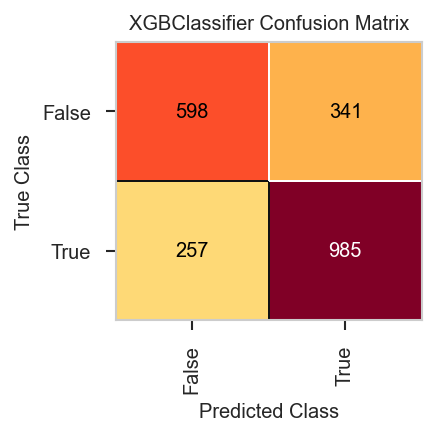

In [120]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(3,3), dpi=150)
    cm_viz = classifier.ConfusionMatrix(xgb, precent=False)
    cm_viz.score(X_bin_test, y_bin_test_mod)
    cm_viz.poof()